# LIMIX eQTL analysis

In [2]:
from datetime import date
from pycltools.pycltools import jprint

jprint('Adrien Leger / EMBL EBI', bold=True, size=150)
jprint('Starting date : 2021_02_17', bold=True, italic=True, size=125)
jprint('Last modification date : {}_{:02}_{:02}'.format(date.today().year, date.today().month, date.today().day), bold=True, italic=True, size=125)

## Imports

In [1]:
# Standard lib imports
import os
from os import listdir as ls
from datetime import date
from collections import *
from glob import glob, iglob
from shutil import rmtree
import itertools
from pprint import pprint as pp
import string

# Generic third party imports
from pycltools.pycltools import *
import pysam
import pyfaidx

# Ploting lib imports
import matplotlib.pyplot as pl
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
%matplotlib inline

# Data wrangling lib imports
import pandas as pd
import numpy as np
import scipy as sp
import xarray as xr
#import xarray_extras as xre

# xr.set_options(display_style="html", display_width=500)
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 20
pd.options.display.max_rows = 200

# Limix
import limix
import pandas_plink

## Load and cleanup transcriptome data

In [8]:
outdir = "tx_expression"
rmtree(outdir, ignore_errors=True)
mkdir(outdir)

Creating /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/eQTL_analysis/tx_expression


### Define functions

In [12]:
import scipy.stats as stats

def samples_select (df, samples_id_dict):
    """
    Change ids to line ids and select only liver samples
    """
    col_dict = {}
    for sample_id, col_val in df.iteritems():
        sample_id = sample_id.rstrip("_counts")
        if sample_id in samples_id_dict:
            line_id = samples_id_dict[sample_id]
            col_dict[line_id] = col_val

    # Cast to df and sort columns alphabetically
    df = pd.DataFrame.from_dict(col_dict)
    df = df[df.columns.sort_values()]
    df.index.name="transcripts"
    return df

def filter_low_expression (counts_df, tpm_df, sample_frac_threshold=0.2, count_threshold=6, tpm_threshold=1):
    """
    Genes are thresholded based on the following expression rules:
      TPM >= tpm_threshold in >= sample_frac_threshold*samples
      read counts >= count_threshold in sample_frac_threshold*samples
    """
    n_samples = int(len(tpm_df.columns)*sample_frac_threshold)
    
    # Expression thresholds
    mask = ((np.sum(tpm_df>=tpm_threshold,axis=1)>=n_samples) & (np.sum(counts_df>=count_threshold,axis=1)>=n_samples)).values
    
    return tpm_df[mask]

### Load and prefilter

In [68]:
print("Load data")
samples_id_df = pd.read_csv("../RNA_pipeline2/all_sample_sheet.tsv", index_col=0, sep="\t")
samples_id_df = samples_id_df[(samples_id_df.protocol=="high")&((samples_id_df.organ=="liver"))]
samples_id_dict = samples_id_df["line"]

tpm_df = pd.read_csv("../RNA_pipeline2/results/counts/salmon_count_merge/tpm.tsv", index_col=0, sep="\t").fillna(0)
counts_df = pd.read_csv("../RNA_pipeline2/results/counts/salmon_count_merge/counts.tsv", index_col=0, sep="\t").fillna(0)
print(f"\tInitial Number of Samples:{len(tpm_df.columns)}")
print(f"\tInitial Number of Transcripts:{len(tpm_df.index)}")

print("Switch ids to line ids and select samples")
tpm_df = samples_select(tpm_df, samples_id_dict)
counts_df = samples_select(counts_df, samples_id_dict)
print(f"\tSamples remaining after sample selection:{len(tpm_df.columns)}")

print("Filter low expression transcripts")
tpm_df = filter_low_expression (counts_df, tpm_df, sample_frac_threshold=0.5, count_threshold=5, tpm_threshold=1)
print(f"\tTranscripts remaining after expression filtering: {len(tpm_df)}")

Load data
	Initial Number of Samples:145
	Initial Number of Transcripts:36777
Switch ids to line ids and select samples
	Samples remaining after sample selection:50
Filter low expression transcripts
	Transcripts remaining after expression filtering: 13413


### Visualisation

Apply log 2 transformation


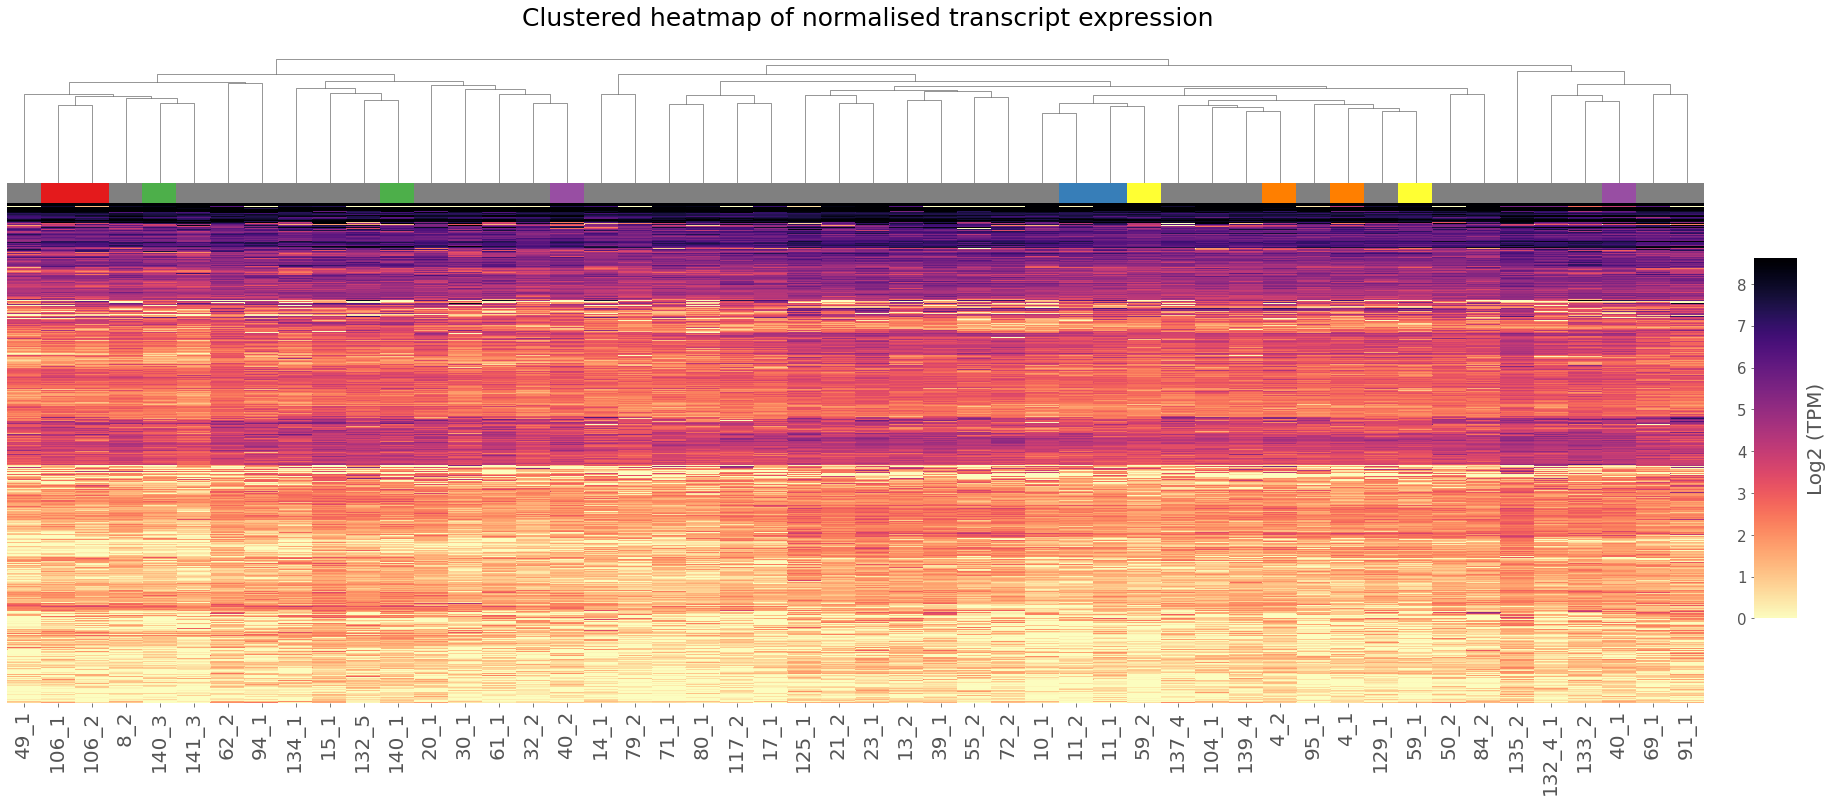

In [91]:
# VISUALIZATION
tpm_df2 = tpm_df.copy()
tpm_df2.clip(1, inplace=True)
tpm_df2.fillna(1, inplace=True)

# Define color per organ
c = Counter()
for col in tpm_df2.columns:
    c[col.rpartition("_")[0]]+=1

sib_lines = [i for i,j in c.items() if j>1]
pal = sns.mpl_palette("Set1", len(sib_lines))
color_dict={i:j for i,j in zip(sib_lines, pal)}
color_map = [color_dict.get(line.split("_")[0], "grey") for line in tpm_df2.columns]

print("Apply log 2 transformation")
log_tpm_df = np.log2(tpm_df2.fillna(1))
with pl.style.context("ggplot"):
    g = sns.clustermap(log_tpm_df, figsize=(30, 10), row_cluster=True, cmap="magma_r", yticklabels=False, dendrogram_ratio=0.2, robust=True, col_colors=color_map, cbar_pos=(1.01,0.2,0.02,0.5))
    g.ax_heatmap.set_ylabel("")
    g.ax_heatmap.tick_params(axis='x', labelsize=20)
    g.ax_row_dendrogram.remove()
    g.ax_cbar.set_ylabel("Log2 (TPM)", fontsize=20, labelpad=10)
    g.ax_cbar.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False, labelsize=15)
    g.fig.suptitle("Clustered heatmap of normalised transcript expression", fontsize=25, y=1.05, x=0.6)
    g.fig.savefig("tx_expression/heatmap.png", bbox_inches='tight')

### Transformation for eQTL analysis

In [19]:
print("Add transcript information")
tx_info_df = pd.read_csv("../RNA_pipeline2/results/input/transcriptome/transcriptome.tsv",sep="\t", index_col=0, low_memory=False)
tx_info_df = tx_info_df[["chrom_id","start","end"]]
tpm_info_df = pd.merge(tpm_df, tx_info_df, left_index=True, right_index=True, how="left")
tpm_info_df = tpm_info_df.sort_values(["chrom_id","start","end"])
tpm_info_df = tpm_info_df.set_index(["chrom_id","start","end", tpm_info_df.index])

print("Save filtered TPM")
tpm_info_df.to_csv("tx_expression/filtered_tpm.tsv", sep="\t")
display(tpm_info_df.head())

print("Apply quantile normalization")
tpm_info_df = limix.qc.quantile_gaussianize(tpm_info_df, axis=0)

print("Save normalised TPM")
tpm_info_df.to_csv("tx_expression/filtered_norm_tpm.tsv", sep="\t")
display(tpm_info_df.head())

Add transcript information
Save filtered TPM


104_1       106_1  \
chrom_id start  end    transcripts                                    
1        89782  91495  ENSORLT00000038242.1  132.398744  147.278974   
         92003  119620 ENSORLT00000024712.2    2.851773    2.068150   
         92256  119620 ENSORLT00000028495.1   12.713114    9.962724   
         103603 105216 ENSORLT00000046555.1    1.669206    1.415191   
         149638 154759 ENSORLT00000046412.1    7.072590    5.485392   

                                                  106_2        10_1  \
chrom_id start  end    transcripts                                    
1        89782  91495  ENSORLT00000038242.1  131.147592  136.561629   
         92003  119620 ENSORLT00000024712.2    2.905608    2.485323   
         92256  119620 ENSORLT00000028495.1    9.109646   11.261207   
         103603 105216 ENSORLT00000046555.1    2.351947    1.128440   
         149638 154759 ENSORLT00000046412.1    6.777299    6.015674   

                                                  117_2        11_1  \
chrom_id start  end    transcripts                                    
1        89782  91495  ENSORLT00000038242.1  169.749287  130.926732   
         92003  119620 ENSORLT00000024712.2    3.389430    2.856913   
         92256  119620 ENSORLT00000028495.1    9.842299   12.790680   
         103603 105216 ENSORLT00000046555.1    5.744599   11.602346   
         149638 154759 ENSORLT00000046412.1    6.997350    9.465706   

                                                   11_2       125_1  \
chrom_id start  end    transcripts                                    
1        89782  91495  ENSORLT00000038242.1  157.198133  146.350480   
         92003  119620 ENSORLT00000024712.2    4.457706    4.539562   
         92256  119620 ENSORLT00000028495.1   12.319639   13.758069   
         103603 105216 ENSORLT00000046555.1    1.187426    0.755808   
         149638 154759 ENSORLT00000046412.1    9.482291   12.086758   

                                                 129_1     132_4_1  ...  \
chrom_id start  end    transcripts                                  ...   
1        89782  91495  ENSORLT00000038242.1  99.049843  187.219082  ...   
         92003  119620 ENSORLT00000024712.2   3.923271    6.370960  ...   
         92256  119620 ENSORLT00000028495.1   9.896707   21.283193  ...   
         103603 105216 ENSORLT00000046555.1   7.442255    6.913771  ...   
         149638 154759 ENSORLT00000046412.1   7.756801    9.597334  ...   

                                                   69_1        71_1  \
chrom_id start  end    transcripts                                    
1        89782  91495  ENSORLT00000038242.1  216.666476  150.089135   
         92003  119620 ENSORLT00000024712.2    8.704263    3.262110   
         92256  119620 ENSORLT00000028495.1   24.651957   16.870579   
         103603 105216 ENSORLT00000046555.1   12.660029    1.446606   
         149638 154759 ENSORLT00000046412.1   15.068356    6.778361   

                                                   72_2        79_2  \
chrom_id start  end    transcripts                                    
1        89782  91495  ENSORLT00000038242.1  158.648856  200.852472   
         92003  119620 ENSORLT00000024712.2    4.197748    4.310642   
         92256  119620 ENSORLT00000028495.1   13.309991   13.064007   
         103603 105216 ENSORLT00000046555.1    0.740902    1.526337   
         149638 154759 ENSORLT00000046412.1   13.311218    4.803048   

                                                  80_1       84_2         8_2  \
chrom_id start  end    transcripts                                              
1        89782  91495  ENSORLT00000038242.1  90.601927  90.799860  401.441801   
         92003  119620 ENSORLT00000024712.2   1.477848   5.733650    2.524696   
         92256  119620 ENSORLT00000028495.1   7.099399  23.960132   10.194435   
         103603 105216 ENSORLT00000046555.1   1.427790   1.164756    1.117233   
         149638 154759 ENSORLT00000046412.1   4.57

Apply quantile normalization
Save normalised TPM


104_1     106_1     106_2  \
chrom_id start  end    transcripts                                          
1        89782  91495  ENSORLT00000038242.1 -1.092736 -0.786845 -1.186831   
         92003  119620 ENSORLT00000024712.2 -0.721522 -1.092736 -0.599230   
         92256  119620 ENSORLT00000028495.1 -0.223008 -1.092736 -1.415702   
         103603 105216 ENSORLT00000046555.1 -0.123185 -0.430727  0.223008   
         149638 154759 ENSORLT00000046412.1 -0.377392 -1.186831 -0.721522   

                                                 10_1     117_2      11_1  \
chrom_id start  end    transcripts                                          
1        89782  91495  ENSORLT00000038242.1 -1.007436 -0.273702 -1.292805   
         92003  119620 ENSORLT00000024712.2 -0.928899 -0.377392 -0.659143   
         92256  119620 ENSORLT00000028495.1 -0.541395 -1.292805 -0.172881   
         103603 105216 ENSORLT00000046555.1 -0.928899  0.786845  1.415702   
         149638 154759 ENSORLT00000046412.1 -1.092736 -0.430727  0.541395   

                                                 11_2     125_1     129_1  \
chrom_id start  end    transcripts                                          
1        89782  91495  ENSORLT00000038242.1 -0.541395 -0.855712 -1.415702   
         92003  119620 ENSORLT00000024712.2  0.172881  0.223008 -0.073791   
         92256  119620 ENSORLT00000028495.1 -0.273702 -0.024577 -1.186831   
         103603 105216 ENSORLT00000046555.1 -0.599230 -1.292805  1.007436   
         149638 154759 ENSORLT00000046412.1  0.599230  1.007436 -0.073791   

                                              132_4_1  ...      69_1  \
chrom_id start  end    transcripts                     ...             
1        89782  91495  ENSORLT00000038242.1 -0.073791  ...  0.273702   
         92003  119620 ENSORLT00000024712.2  0.928899  ...  1.564726   
         92256  119620 ENSORLT00000028495.1  0.928899  ...  1.564726   
         103603 105216 ENSORLT00000046555.1  0.928899  ...  1.759861   
         149638 154759 ENSORLT00000046412.1  0.659143  ...  1.759861   

                                                 71_1      72_2      79_2  \
chrom_id start  end    transcripts                                          
1        89782  91495  ENSORLT00000038242.1 -0.721522 -0.485318  0.123185   
         92003  119620 ENSORLT00000024712.2 -0.430727  0.024577  0.073791   
         92256  119620 ENSORLT00000028495.1  0.377392 -0.073791 -0.123185   
         103603 105216 ENSORLT00000046555.1 -0.273702 -1.415702 -0.223008   
         149638 154759 ENSORLT00000046412.1 -0.659143  1.564726 -1.415702   

                                                 80_1      84_2       8_2  \
chrom_id start  end    transcripts                                          
1        89782  91495  ENSORLT00000038242.1 -2.061917 -1.759861  1.292805   
         92003  119620 ENSORLT00000024712.2 -1.415702  0.659143 -0.855712   
         92256  119620 ENSORLT00000028495.1 -2.061917  1.415702 -1.007436   
         103603 105216 ENSORLT00000046555.1 -0.325110 -0.659143 -1.007436   
         149638 154759 ENSORLT00000046412.1 -1.759861  0.721522  0.223008   

                                                 91_1      94_1      95_1  
chrom_id start  end    transcripts                                         
1        89782  91495  ENSORLT00000038242.1  2.061917  0.485318  0.223008  
         92003  119620 ENSORLT00000024712.2  0.377392 -1.186831 -0.273702  
         92256  119620 ENSORLT00000028495.1  0.721522 -0.928899  0.073791  
         103603 105216 ENSORLT00000046555.1  2.061917  0.541395 -0.541395  
         149638 154759 ENSORLT00000046412.1  0.485318 -2.061917 -0.786845  

[5 rows x 50 columns]

#### Plot TPM values distribution

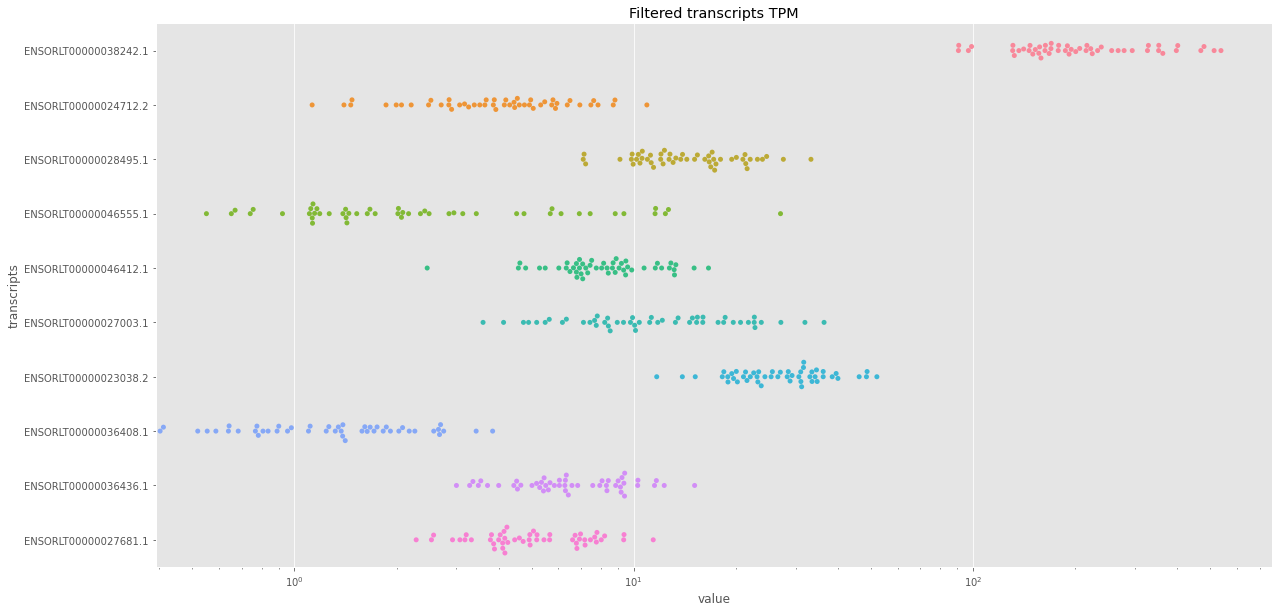

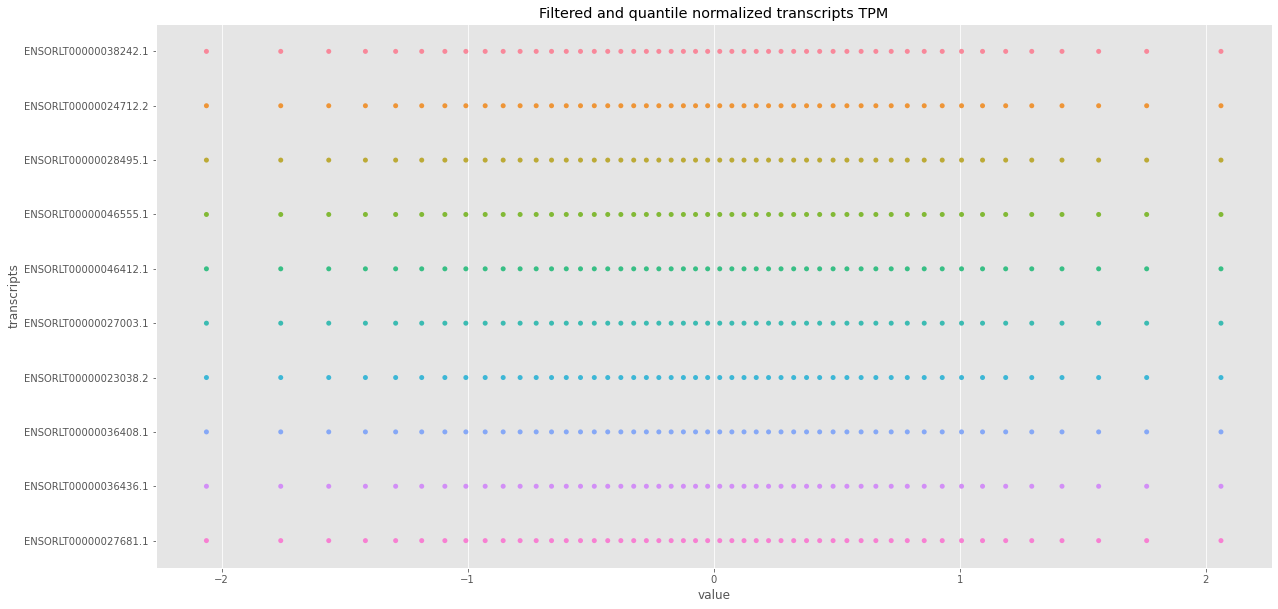

In [21]:
n_genes = 10

df =pd.read_csv("tx_expression/filtered_tpm.tsv", sep="\t", index_col=[0,1,2,3])
df = df.head(n_genes).T.melt()
with pl.style.context("ggplot"):
    fig, ax = pl.subplots(figsize=(20,n_genes))
    ax.set_title("Filtered transcripts TPM")
    ax.set_xscale("log")
    sns.swarmplot(y="transcripts", x="value", data=df, ax=ax)
    
df =pd.read_csv("tx_expression/filtered_norm_tpm.tsv", sep="\t", index_col=[0,1,2,3])
df = df.head(n_genes).T.melt()
with pl.style.context("ggplot"):
    fig, ax = pl.subplots(figsize=(20,n_genes))
    ax.set_title("Filtered and quantile normalized transcripts TPM")
    sns.swarmplot(y="transcripts", x="value", data=df, ax=ax)
    

## Convert to PLINK format

In [22]:
src_vcf = "/nfs/research1/birney/projects/indigene/datafreeze/14-03-2019/vcf/medaka_inbred_panel_ensembl_new_reference_release_94.vcf.gz"
head(src_vcf, ignore_comment_line=True, comment_char="##")

#CHROM POS  ID REF             ALT             QUAL    FILTER INFO                                               FORMAT                 22013_2#1             22013_2#2             22013_2#3           ...
1      4156 .  G               T               54.74   .      AC=2;AF=0.143;AN=14;DP=19;ExcessHet=0.1703;FS=0.00 GT:AD:DP:GQ:PL         ./.:0,0:0:.:0,0,0     ./.:0,0:0:.:0,0,0     ./.:0,0:0:.:0,0,0   ...
1      4599 .  T               TCTTCTTCTCA     1094.74 .      AC=10;AF=0.625;AN=16;DP=26;ExcessHet=0.0152;FS=0.0 GT:AD:DP:GQ:PL         ./.:0,0:0:.:0,0,0     ./.:0,0:0:.:0,0,0     ./.:0,0:0:.:0,0,0   ...
1      4653 .  A               G               798.22  .      AC=10;AF=1.00;AN=10;DP=24;ExcessHet=3.0103;FS=0.00 GT:AD:DP:GQ:PL         ./.:0,0:0:.:0,0,0     ./.:0,0:0:.:0,0,0     ./.:0,0:0:.:0,0,0   ...
1      5039 .  T               G               62.79   .      AC=2;AF=1.00;AN=2;DP=13;ExcessHet=3.0103;FS=0.000; GT:AD:DP:GQ:PL         ./.:0,0:0:.:0,0,0     ./.:0,0:0:.:0,0,0     ./.:

### Convert

In [106]:
src_vcf = "/nfs/research1/birney/projects/indigene/datafreeze/14-03-2019/vcf/medaka_inbred_panel_ensembl_new_reference_release_94.vcf.gz"
raw_outdir = "plink_raw"
rmtree(raw_outdir, ignore_errors=True)
mkdir(raw_outdir)

mem = 10000
threads = 20
queue = "research-rh74"
dry=False
stderr_fp=f"{raw_outdir}/bsub_stderr.txt"
stdout_fp=f"{raw_outdir}/bsub_stdout.txt"

jobid = bsub (
    cmd = f"plink --vcf {src_vcf} --make-bed --snps-only --chr-set 24 no-xy --out {raw_outdir}/medaka --memory {mem} --threads {threads}",
    conda="plink", threads=threads, mem=mem, queue=queue, dry=dry, stderr_fp=stderr_fp, stdout_fp=stdout_fp)

Creating /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/eQTL_analysis/plink_raw
bsub -M 10000 -R 'rusage[mem=10000]' -n 20 -q research-rh74 -oo plink_raw/bsub_stdout.txt -eo plink_raw/bsub_stderr.txt  "plink --vcf /nfs/research1/birney/projects/indigene/datafreeze/14-03-2019/vcf/medaka_inbred_panel_ensembl_new_reference_release_94.vcf.gz --make-bed --snps-only --chr-set 24 no-xy --out plink_raw/medaka --memory 10000 --threads 20"
Job <949307> is submitted to queue <research-rh74>.


### Fix plink files

In [108]:
fixed_outdir = "plink_metadata_fixed"
rmtree(fixed_outdir, ignore_errors=True)
mkdir(fixed_outdir)

print("Redefine sex, FAM ID and IID in FAM file")
df = pd.read_csv(f"{raw_outdir}/medaka.fam", sep=" ", names=["FID", "IID", "F_IID", "M_IID", "Sex", "Phenotype"])
sample_id_df = pd.read_csv("internal_id.tsv", sep="\t", index_col=0)

for i, line in df.iterrows():
    internal_id = f"{line.FID}_{line.IID}"
    sample_id = sample_id_df.loc[internal_id]
    df.loc[i, "FID"] = sample_id["FID"]
    df.loc[i, "IID"] = sample_id["IID"]
    df.loc[i, "Sex"] = 1
df.to_csv(f"{fixed_outdir}/medaka.fam", sep=" ", header=False, index=False)
display(df.head())

print("Redefine snp_id in BIM file")
df = pd.read_csv(f"{raw_outdir}/medaka.bim", sep="\t", names=["CHR", "VID", "POS_M", "POS_B", "AL1", "AL2"])
df["VID"] = [f"rs_{i}" for i in range(len(df))]
df.to_csv(f"{fixed_outdir}/medaka.bim", sep="\t", header=False, index=False)
display(df.head())

print("Copy bed file")
shutil.copy2(f"{raw_outdir}/medaka.bed", fixed_outdir)

Creating /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/eQTL_analysis/plink_metadata_fixed
Redefine sex, FAM ID and IID in FAM file


FID   IID  F_IID  M_IID  Sex  Phenotype
0  MIKK  25_1      0      0    1         -9
1  MIKK  30_1      0      0    1         -9
2  MIKK  11_2      0      0    1         -9
3  MIKK  13_2      0      0    1         -9
4  MIKK  14_1      0      0    1         -9

Redefine snp_id in BIM file


CHR   VID  POS_M  POS_B AL1 AL2
0    1  rs_0      0   4156   T   G
1    1  rs_1      0   4653   A   G
2    1  rs_2      0   5039   T   G
3    1  rs_3      0   5123   G   A
4    1  rs_4      0   5613   A   C

Copy bed file


'plink_metadata_fixed/medaka.bed'

### Remove-non panel samples

In [109]:
panel_outdir = "plink_panel_only"
rmtree(panel_outdir, ignore_errors=True)
mkdir(panel_outdir)

Creating /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/eQTL_analysis/plink_panel_only


In [110]:
print ("Load data")
df = pd.read_csv("/nfs/research1/birney/projects/indigene/raw_data/sanger_pipeline/G2035/G2035_metadata_03-14-19.txt", sep="\t")
tpm_line_ids = list(pd.read_csv("./tx_expression/filtered_tpm.tsv", sep="\t", index_col=0).columns)

internal_id_dict = {}
line_id_counter = Counter()

print("Get correspondance between internal ids and line ids")
for idx, line in df.iterrows():
    line_id = line["supplier_name"].replace(" ", "_").replace("--", "_").replace("-", "_")
    
    fam_id = line_id.split("_")[0]
    if fam_id.isdigit():
        fam_id="MIKK"
        
    line_id_counter[line_id]+=1
    if line_id_counter[line_id]>1:
        sample_rep = string.ascii_uppercase[line_id_counter[line_id]-1]
        line_id = f"{line_id}.{sample_rep}"
    
    rna_seq = line_id in tpm_line_ids
    internal_id = line["cram_file_names"].split(".")[0]
    internal_id_dict[internal_id] = (fam_id, line_id, rna_seq)
    
df = pd.DataFrame.from_dict(internal_id_dict, orient="index", columns=["FID", "IID", "RNAseq"])
df = df.sort_values(["FID", "IID"])
display(df)

df.to_csv(f"{panel_outdir}/internal_id.tsv", sep="\t")

Load data
Get correspondance between internal ids and line ids


FID       IID  RNAseq
22024_4#1   Ho5     Ho5_1   False
22024_4#2   Ho5     Ho5_2   False
24300_8#2    KW      KW_1   False
24300_8#3    KW      KW_2   False
24300_8#4    KW      KW_3   False
24300_8#5    KW      KW_4   False
24271_7#1    KW      KW_5   False
24271_7#2    KW      KW_6   False
24271_7#3    KW      KW_7   False
22218_1#3  MIKK     104_1    True
22218_1#4  MIKK     106_1    True
22218_1#5  MIKK     106_2    True
22218_5#1  MIKK     107_2   False
22218_4#5  MIKK      10_1    True
22218_6#1  MIKK     110_2   False
22013_6#4  MIKK     117_1   False
22218_6#2  MIKK     117_2    True
22218_4#1  MIKK      11_1    True
22013_2#3  MIKK      11_2    True
24259_1#3  MIKK     121_2   False
22218_6#3  MIKK     123_2   False
24259_1#4  MIKK     125_1    True
22218_6#4  MIKK     127_2   False
22013_6#5  MIKK     129_1    True
22218_6#5  MIKK     131_1   False
22218_2#3  MIKK     131_2   False
22218_2#4  MIKK     131_4   False
24259_1#5  MIKK   132_4_1    True
22218_7#4  MIKK     132_5    True
22218_2#5  MIKK     133_2    True
22218_7#5  MIKK     134_1    True
22218_7#1  MIKK     134_2   False
22218_7#2  MIKK     134_3   False
22218_7#3  MIKK     135_1   False
24259_2#1  MIKK     135_2    True
22218_8#2  MIKK     136_2   False
22218_8#3  MIKK     137_4    True
24259_2#2  MIKK     138_1   False
22218_8#4  MIKK     138_3   False
22218_8#5  MIKK     139_4    True
22013_2#4  MIKK      13_2    True
22218_8#6  MIKK     140_1    True
22218_8#1  MIKK     140_3    True
22218_2#1  MIKK     141_3    True
24259_2#3  MIKK   141_3.B   False
24259_2#4  MIKK     141_4   False
22013_2#5  MIKK      14_1    True
22024_1#1  MIKK      14_2   False
22218_4#2  MIKK      15_1    True
22218_4#3  MIKK      15_2   False
22024_1#2  MIKK      17_1    True
22024_1#3  MIKK      18_2   False
22218_4#4  MIKK      20_1    True
22024_1#4  MIKK      21_2    True
22024_1#5  MIKK      22_1   False
22013_3#1  MIKK      23_1    True
22013_3#2  MIKK      23_2   False
22013_2#1  MIKK      25_1   False
24271_7#4  MIKK      29_1   False
22013_2#2  MIKK      30_1    True
22013_3#3  MIKK      31_2   False
22013_3#4  MIKK      32_2    True
24271_7#5  MIKK    32_2.B   False
22013_3#5  MIKK      33_1   False
24271_8#1  MIKK      34_2   False
22024_2#1  MIKK      38_2   False
22024_2#2  MIKK      39_1    True
22024_2#3  MIKK      39_2   False
22024_2#4  MIKK      40_1    True
22024_2#5  MIKK      40_2    True
22013_4#1  MIKK      42_1   False
22013_4#2  MIKK      43_2   False
22013_4#3  MIKK      47_1   False
22218_5#2  MIKK      49_1    True
22013_4#4  MIKK      49_2   False
22218_2#2  MIKK       4_1    True
22218_3#1  MIKK       4_2    True
22013_4#5  MIKK      50_2    True
22013_5#1  MIKK      51_2   False
22013_5#2  MIKK      53_2   False
22013_5#3  MIKK      55_2    True
22013_5#4  MIKK      56_1   False
22013_5#5  MIKK      58_2   False
22024_3#1  MIKK      59_1    True
22024_3#2  MIKK      59_2    True
22218_3#2  MIKK       5_1   False
24271_8#2  MIKK      60_1   False
22024_3#3  MIKK      61_1    True
22024_3#4  MIKK      62_2    True
22218_1#1  MIKK      66_1   False
24271_8#3  MIKK      68_1   False
22218_5#3  MIKK      69_1    True
22024_3#5  MIKK      69_2   False
22013_7#1  MIKK      70_2   False
22013_7#2  MIKK      71_1    True
24271_8#4  MIKK    71_1.B   False
22013_7#3  MIKK      72_1   False
22013_7#4  MIKK      72_2    True
22013_7#5  MIKK      75_1   False
22218_5#4  MIKK      79_2    True
22218_3#3  MIKK       7_1   False
22218_3#4  MIKK       7_2   False
22218_5#5  MIKK      80_1    True
24271_8#5  MIKK      80_2   False
22013_6#1  MIKK      84_2    True
24259_1#1  MIKK    84_2.B   False
24259_1#2  MIKK      89_1   False
22218_3#5  MIKK       8_2    True
22218_1#2  MIKK      91_1    True
22013_6#2  MIKK      94_1    True
22013_6#3  MIKK      95_1    True
22024_4#4  iCab  iCab_2F2   False
22024_4#3  iCab  iCab_F24   False
24300_8#1  iCab  iCab_F25   False
22024_4#5  iCab   iCab_HD   False

In [111]:
# Extract IDs corresponding to pannel members with data in the transcriptome dataset 
sample_id_df = pd.read_csv(f"{panel_outdir}/internal_id.tsv", sep="\t", index_col=0)
sample_id_df = sample_id_df[sample_id_df["RNAseq"]==True]
id_file = f"{panel_outdir}/fam_id.txt"
with open (id_file, "w") as fp:
    for i, line in sample_id_df.iterrows():
        fp.write(f"{line.FID}\t{line.IID}\n")
    
print("Select MIKK panel samples only")
mem = 10000
threads = 20
queue = "research-rh74"
dry=False
stderr_fp=f"{panel_outdir}/bsub_stderr.txt"
stdout_fp=f"{panel_outdir}/bsub_stdout.txt"

jobid = bsub (
    cmd = f"plink --keep {id_file} --make-bed --chr-set 24 no-xy --bfile {fixed_outdir}/medaka --out {panel_outdir}/medaka --memory {mem} --threads {threads}",
    conda="plink", threads=threads, mem=mem, queue=queue, dry=dry, stderr_fp=stderr_fp, stdout_fp=stdout_fp)

Select MIKK panel samples only
bsub -M 10000 -R 'rusage[mem=10000]' -n 20 -q research-rh74 -oo plink_panel_only/bsub_stdout.txt -eo plink_panel_only/bsub_stderr.txt  "plink --keep plink_panel_only/fam_id.txt --make-bed --chr-set 24 no-xy --bfile plink_metadata_fixed/medaka --out plink_panel_only/medaka --memory 10000 --threads 20"
Job <1058693> is submitted to queue <research-rh74>.


## LD Pruning with PLINK

### prune

In [9]:
panel_outdir = "plink_panel_only"
pruned_outdir = "plink_pruned"
rmtree(pruned_outdir, ignore_errors=True)
mkdir(pruned_outdir)

print("Variant filtering and LD pruning")
mem = 10000
threads = 25
queue = "research-rh74"
dry=False


stderr_fp=f"{pruned_outdir}/bsub_stderr_prune.txt"
stdout_fp=f"{pruned_outdir}/bsub_stdout_prune.txt"

jobid1 = bsub (
    cmd=f"plink --geno 0 --maf 0.001 --indep 50 5 5 --chr-set 24 no-xy --bfile {panel_outdir}/medaka --out {pruned_outdir}/medaka --memory {mem} --threads {threads}",
    conda="plink", threads=threads, mem=mem, queue=queue, dry=dry, stderr_fp=stderr_fp, stdout_fp=stdout_fp)

stderr_fp=f"{pruned_outdir}/bsub_stderr_extract.txt"
stdout_fp=f"{pruned_outdir}/bsub_stdout_extract.txt"

jobid2 = bsub (
    cmd=f"plink --extract {pruned_outdir}/medaka.prune.in --chr-set 24 no-xy --make-bed --bfile {panel_outdir}/medaka --out {pruned_outdir}/medaka --memory {mem} --threads {threads}",
    conda="plink", threads=threads, mem=mem, queue=queue, dry=dry, stderr_fp=stderr_fp, stdout_fp=stdout_fp, wait_jobid=jobid1)

Creating /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/eQTL_analysis/plink_pruned
Variant filtering and LD pruning
bsub -M 10000 -R 'rusage[mem=10000]' -n 25 -q research-rh74 -oo plink_pruned/bsub_stdout_prune.txt -eo plink_pruned/bsub_stderr_prune.txt  "plink --geno 0 --maf 0.001 --indep 50 5 5 --chr-set 24 no-xy --bfile plink_panel_only/medaka --out plink_pruned/medaka --memory 10000 --threads 25"
Job <2194396> is submitted to queue <research-rh74>.
bsub -M 10000 -R 'rusage[mem=10000]' -n 25 -q research-rh74 -oo plink_pruned/bsub_stdout_extract.txt -eo plink_pruned/bsub_stderr_extract.txt -w 'post_done(2194396)'  "plink --extract plink_pruned/medaka.prune.in --chr-set 24 no-xy --make-bed --bfile plink_panel_only/medaka --out plink_pruned/medaka --memory 10000 --threads 25"
Job <2194400> is submitted to queue <research-rh74>.


In [10]:
bjobs_update(cmd="plink*")

All jobs done


#### Result of pruning

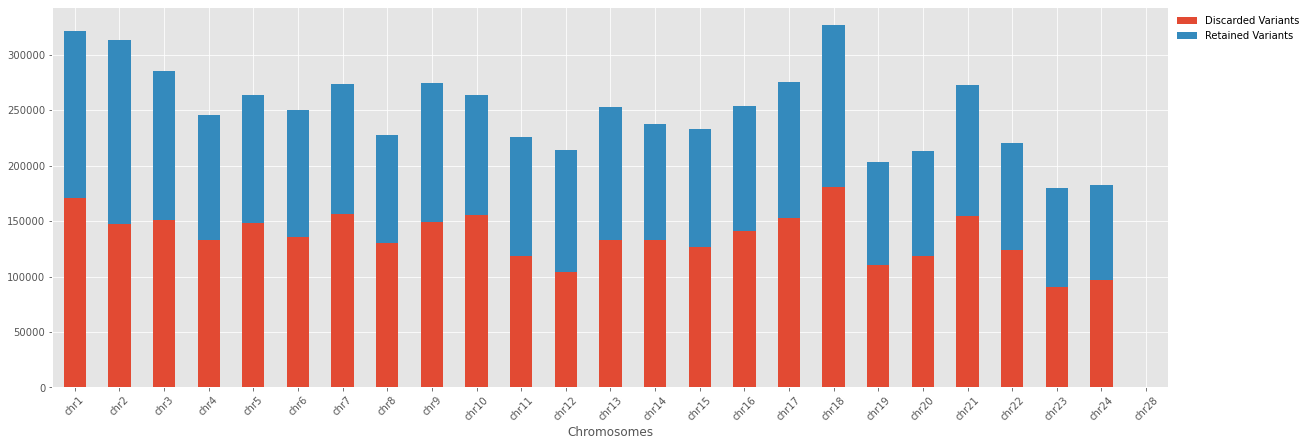

Chromosomes              chr1       chr2       chr3       chr4       chr5  \
Discarded Variants  170427.00  147690.00  151347.00  133107.00  147817.00   
Retained Variants   150988.00  165990.00  134344.00  112762.00  115549.00   
% retained              46.98      52.92      47.02      45.86      43.87   

Chromosomes              chr6       chr7       chr8       chr9      chr10  \
Discarded Variants  135986.00  156386.00  130355.00  149377.00  155806.00   
Retained Variants   114533.00  116858.00   97568.00  125364.00  107652.00   
% retained              45.72      42.77      42.81      45.63      40.86   

Chromosomes         ...      chr17      chr18      chr19      chr20  \
Discarded Variants  ...  152851.00  180856.00  110109.00  118605.00   
Retained Variants   ...  122495.00  145935.00   93288.00   94625.00   
% retained          ...      44.49      44.66      45.86      44.38   

Chromosomes             chr21      chr22     chr23     chr24   chr28  \
Discarded Variants  154551.00  124336.00  90119.00  97291.00  146.00   
Retained Variants   117915.00   95979.00  89572.00  85112.00   58.00   
% retained              43.28      43.56     49.85     46.66   28.43   

Chromosomes               all  
Discarded Variants  3263490.0  
Retained Variants   2747037.0  
% retained               45.7  

[3 rows x 26 columns]

In [13]:
pruned_outdir = "plink_pruned"
l = []
with open (f"{pruned_outdir}/bsub_stdout_prune.txt") as fp:
    for line in fp:
        if line.startswith("Pruned"):
            ls = supersplit(line, [" ", ",", "."])
            chrom=f"chr{ls[5]}"
            init_var = int(ls[1])
            retained_var = int(ls[8])
            discarded_var = init_var-retained_var
            l.append((chrom, discarded_var, retained_var))

df = pd.DataFrame(l, columns=["Chromosomes", "Discarded Variants", "Retained Variants"])
df = df.set_index("Chromosomes")

with pl.style.context("ggplot"):
    fig, ax = pl.subplots(figsize=(20,7))
    df.plot.bar(stacked=True, ax=ax, rot=45)
    _ = ax.legend(bbox_to_anchor=(1, 1), loc=2, facecolor="white", frameon=False)
    pl.show()

df.loc["all"] = df.sum()
df["% retained"] = (df["Retained Variants"]/(df["Retained Variants"]+df["Discarded Variants"])*100).round(2)
display(df.T)

## LIMIX eQTL analysis

In [42]:
outdir = "limix"
rmtree(outdir, ignore_errors=True)
mkdir(outdir)

Creating /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/eQTL_analysis/limix


#### Load in limix

In [2]:
genotypes = pandas_plink.read_plink1_bin (
    bed=f"plink_pruned/medaka.bed",
    bim=f"plink_pruned/medaka.bim",
    fam=f"plink_pruned/medaka.fam",
    verbose=True)

genotypes = genotypes.sortby("sample")
print (f"Variants imported {len(genotypes.variant)}")
display(genotypes)

Mapping files: 100%|██████████| 3/3 [00:14<00:00,  4.96s/it]


Variants imported 2747037


/nfs/software/birney/adrien/miniconda3/envs/eQTL/lib/python3.6/site-packages/xarray/core/indexing.py:1302: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray 'genotype' (sample: 50, variant: 2747037)>
dask.array<getitem, shape=(50, 2747037), dtype=float64, chunksize=(50, 1024), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object '104_1' '106_1' '106_2' ... '91_1' '94_1' '95_1'
  * variant  (variant) object '1_rs_61' '1_rs_63' ... '28_rs_23770825'
    fid      (sample) <U4 'MIKK' 'MIKK' 'MIKK' 'MIKK' ... 'MIKK' 'MIKK' 'MIKK'
    iid      (sample) <U7 '104_1' '106_1' '106_2' ... '91_1' '94_1' '95_1'
    father   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) <U1 '1' '1' '1' '1' '1' '1' ... '1' '1' '1' '1' '1' '1'
    trait    (sample) float64 -9.0 -9.0 -9.0 -9.0 -9.0 ... -9.0 -9.0 -9.0 -9.0
    chrom    (variant) <U2 '1' '1' '1' '1' '1' '1' ... '28' '28' '28' '28' '28'
    snp      (variant) <U11 'rs_61' 'rs_63' ... 'rs_23770804' 'rs_23770825'
    cm       (variant) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pos      (variant) int64 15591 15600 15630 15635 ... 14581 15450 15451 16457
    a0       (variant) <U1 'G' 'A' 'A' 'A' 'T' 'A' ... 'C' 'G' 'C' 'C' 'G' 'A'
    a1       (variant) <U1 'C' 'T' 'G' 'C' 'A' 'T' ... 'T' 'T' 'T' 'T' 'A' 'G'

#### Compute kinship matrix

In [3]:
kinship = limix.stats.linear_kinship(genotypes, verbose=True)
kinship = pd.DataFrame(kinship, index=genotypes.sample.variable, columns=genotypes.sample.variable)
kinship.to_csv("./limix/kinship.tsv", sep="\t")

Kinship: 100%|██████████| 2683/2683 [08:04<00:00,  5.54it/s]


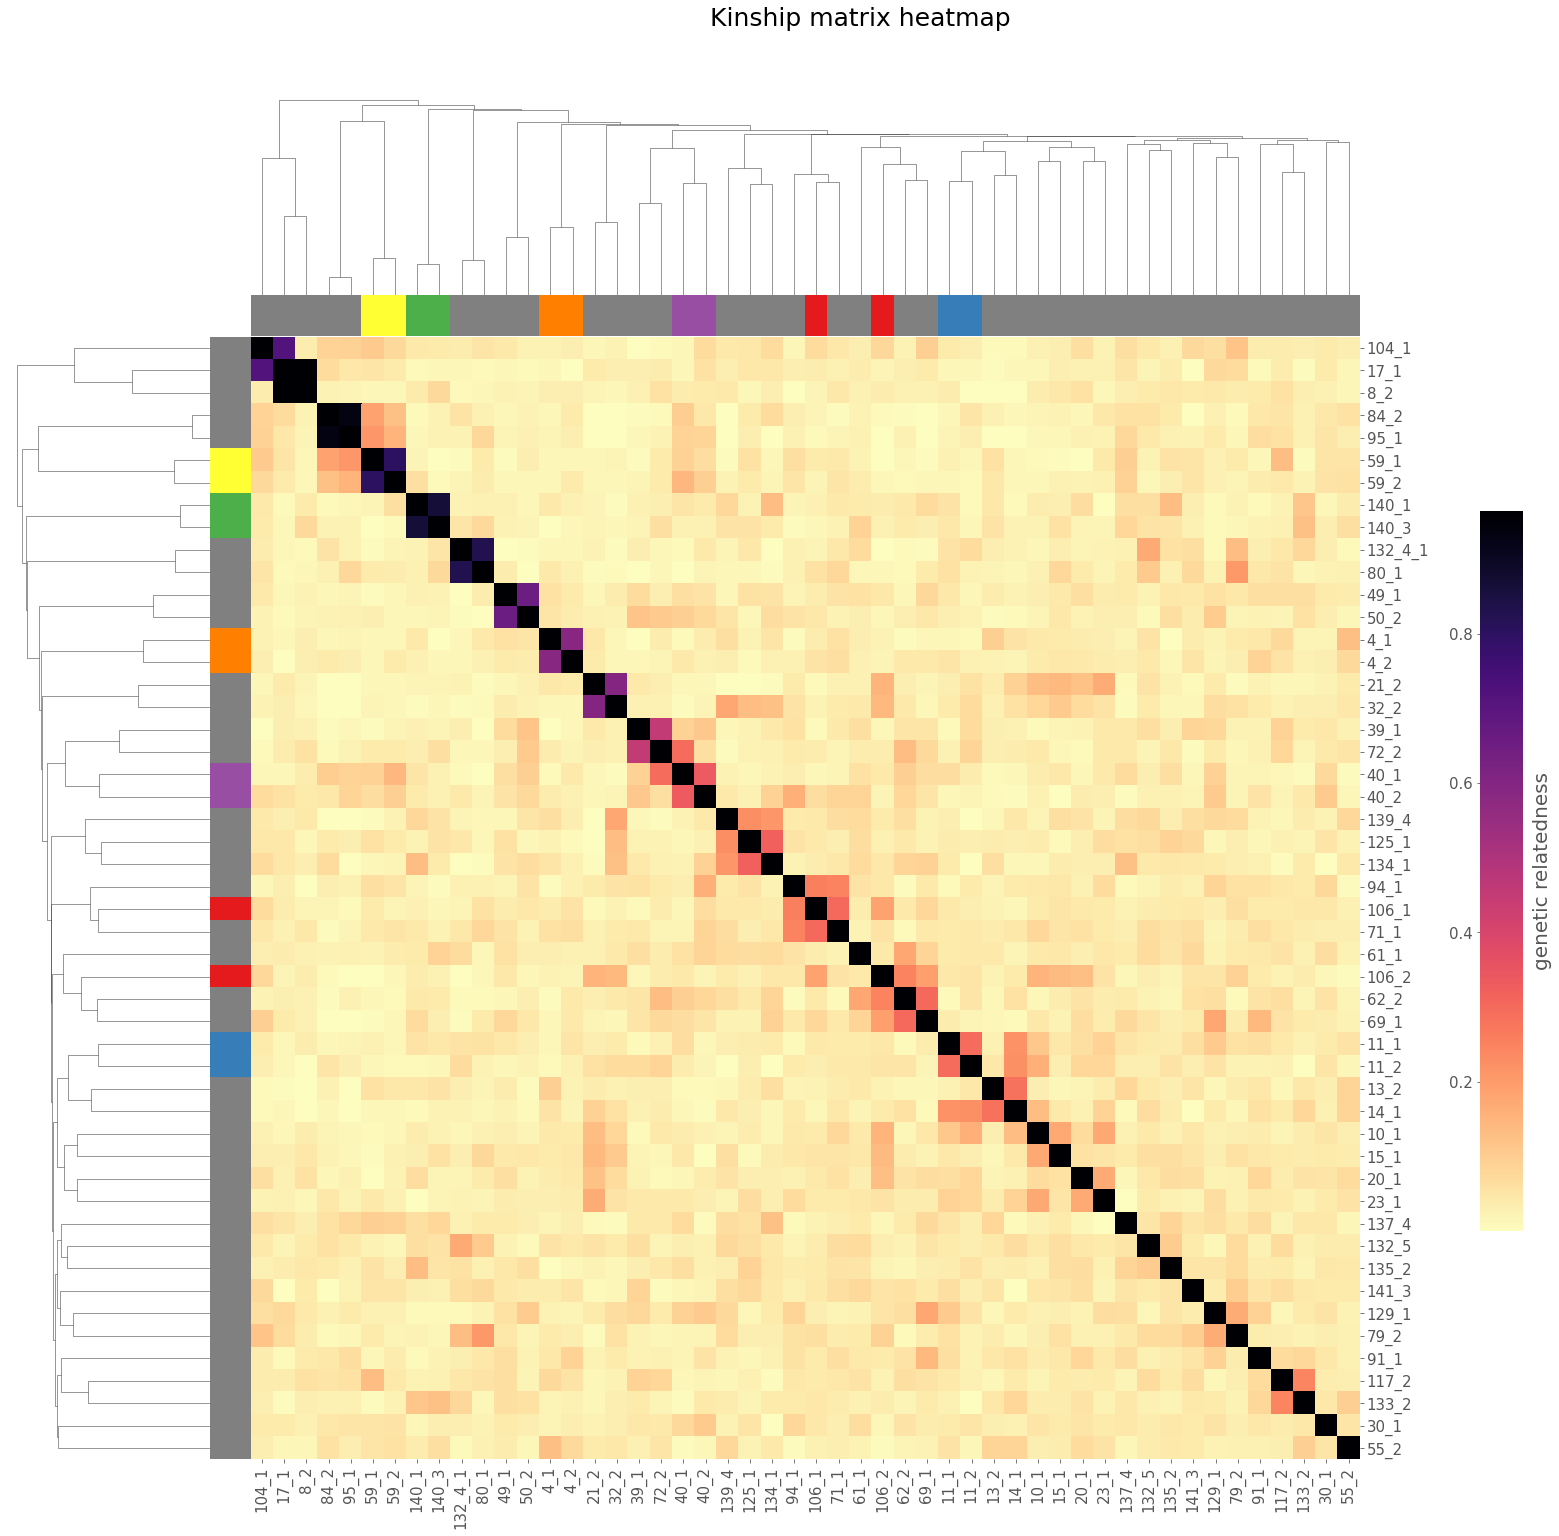

In [93]:
k = pd.read_csv("./limix/kinship.tsv", sep="\t", index_col=0)
cmin, cmax = np.percentile(k.values, [2,98])
k = k.clip(cmin, cmax)
k = (k-cmin)/(cmax-cmin)

line_count = Counter()
for line in k.index:
    line = line.rpartition("_")[0]
    line_count[line]+=1
sib_lines = [i for i,j in line_count.items() if j>=2]
pal = sns.color_palette("Set1", n_colors=len(sib_lines))
col_dict = {i:j for i, j in zip(sib_lines, pal)}
col_cat = []

for line in k.index:
    line = line.rpartition("_")[0]
    col_cat.append(col_dict.get(line, "grey"))

with pl.style.context("ggplot"):
    g = sns.clustermap(k, cmap="magma_r", figsize=(20,20), row_colors=col_cat, col_colors=col_cat, dendrogram_ratio=0.15, robust=True, cbar_pos=(1.03,0.2,0.03,0.5))
    g.ax_heatmap.set_xlabel(None)
    g.ax_heatmap.set_ylabel(None)
    g.ax_cbar.set_ylabel("genetic relatedness", fontsize=20, labelpad=10)
    g.ax_cbar.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False, labelsize=15)
    g.ax_heatmap.tick_params(labelsize=15)
    g.fig.suptitle("Kinship matrix heatmap", fontsize=25, y=1.05, x=0.6)
    g.fig.savefig("limix/kinship_heatmap.png", bbox_inches='tight')

#### Run QTL analysis

In [4]:
from statsmodels.stats.multitest import multipletests
import csv
import warnings
warnings.simplefilter('ignore')

stdout_print("Import data\n")
K = pd.read_csv("./limix/kinship.tsv", sep="\t", index_col=0)
Y = pd.read_csv(f"tx_expression/filtered_norm_tpm.tsv", sep="\t", index_col=[0,1,2,3])
G = pandas_plink.read_plink1_bin (bed=f"plink_pruned/medaka.bed", bim=f"plink_pruned/medaka.bim", fam=f"plink_pruned/medaka.fam", verbose=False)
G = G.sortby("sample")

stdout_print("Run eQTL analysis\n")
extend = 500000
min_pval = np.nextafter(np.float64(0), np.float64(1))
max_pval = 1.0

with open("./limix/eQTL_pval_500k.tsv", "w") as fp:
    writer = csv.DictWriter(fp, fieldnames=["chrom","transcript_id", "pos", "snp_id","pval"], delimiter='\t')
    writer.writeheader()

    for (chrom, start, end, tx), y in tqdm(Y.iterrows(), total=len(Y), ncols=200, mininterval=10):
        if chrom == "MT":
            continue
        try:
            g = G.where(((G.chrom == chrom) & (G.pos>=start-extend) & (G.pos<=end+extend)), drop=True)
            qtl = limix.qtl.scan(G=g, Y=y, K=K, verbose=False)
            
            # Get pValue and correct invalid value
            pval_list = qtl.stats.pv20.values
            pval_list = np.nan_to_num(pval_list, nan=1.0)
            pval_list = np.clip(pval_list, min_pval, max_pval)
            
            for pos, snp_id, pval in zip(g.pos.values, g.snp.values, pval_list):
                writer.writerow({"chrom":chrom,"transcript_id":tx,"pos":pos,"snp_id":snp_id,"pval":pval})
        
        except Exception as E:
            print (f"Exception for transcript {tx} ({chrom}:{start}-{end})")
            print (E)
            continue

Import data
Run eQTL analysis


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13413/13413 [6:46:03<00:00,  1.82s/it]


####  Multiple test adjustment

In [5]:
# Adjust save signifiant hit only and adjust pvalues for multiple tests
print ("Load eQTL results")
df = pd.read_csv("./limix/eQTL_pval_500k.tsv", sep="\t", dtype={"chrom":str})
pval_adj_list = multipletests(df["pval"], alpha=0.1, method='fdr_bh')[1]
pval_adj_list = np.nan_to_num(pval_adj_list, nan=1.0)
pval_adj_list = np.clip(pval_adj_list, min_pval, max_pval)
df["pval"] = pval_adj_list

print ("Write results")
df.to_csv("./limix/eQTL_pval_adj_500k.tsv", index=False, sep="\t")

Load eQTL results
Write results


#### Write significant hits only

In [6]:
print ("Load transcripts info")
tx_info_df = pd.read_csv("../pycoSnake_pipeline/results/input/transcriptome/transcriptome.tsv",sep="\t", dtype={"chrom_id":str})
tx_info_df = tx_info_df[["transcript_id", "gene", "start","end","strand","length", "gene_biotype", "transcript_biotype"]]
tx_info_df = tx_info_df.rename(columns={"gene":"gene_id", "start":"tx_start","end":"tx_end","strand":"tx_strand","length":"tx_length"})

for lab, fn, pval_threshold in [("pval", "./limix/eQTL_pval_500k.tsv", 1e-2), ("pval_adj", "./limix/eQTL_pval_adj_500k.tsv", 1e-2)]:

    print (f"Load eQTL results for {lab}")
    df = pd.read_csv(fn, sep="\t", dtype={"chrom":str})
    df = df[["chrom", "transcript_id", "pos", "snp_id", "pval"]]

    sig_df = df[df["pval"]<=pval_threshold]
    sig_df = pd.merge(sig_df, tx_info_df, on="transcript_id", how="left")
    n_hits = len(sig_df)
    n_tx = sig_df["transcript_id"].nunique()
    n_genes = sig_df["gene_id"].nunique()
    print(f"num hits:{n_hits} / num transcripts:{n_tx} / num genes:{n_genes}")
    
    print (f"Save results to file")
    display (sig_df.head())
    sig_df.to_csv(f"./limix/eQTL_sig_{lab}_500k.tsv", index=False, sep="\t")

Load transcripts info
Load eQTL results for pval
num hits:28030 / num transcripts:5543 / num genes:5115
Save results to file


chrom         transcript_id    pos   snp_id      pval               gene_id  \
0     1  ENSORLT00000038242.1  17674   rs_256  0.008786  ENSORLG00000025034.1   
1     1  ENSORLT00000038242.1  22937   rs_609  0.007728  ENSORLG00000025034.1   
2     1  ENSORLT00000038242.1  47299  rs_1418  0.009680  ENSORLG00000025034.1   
3     1  ENSORLT00000038242.1  47618  rs_1456  0.009345  ENSORLG00000025034.1   
4     1  ENSORLT00000038242.1  49903  rs_1825  0.009684  ENSORLG00000025034.1   

   tx_start  tx_end tx_strand  tx_length    gene_biotype transcript_biotype  
0     89782   91495         +        507  protein_coding     protein_coding  
1     89782   91495         +        507  protein_coding     protein_coding  
2     89782   91495         +        507  protein_coding     protein_coding  
3     89782   91495         +        507  protein_coding     protein_coding  
4     89782   91495         +        507  protein_coding     protein_coding

Load eQTL results for pval_adj
num hits:257 / num transcripts:244 / num genes:244
Save results to file


chrom         transcript_id       pos      snp_id           pval  \
0     1  ENSORLT00000029108.1   1046473    rs_36754   2.690634e-04   
1     1  ENSORLT00000042817.1   4828002   rs_176199   2.690634e-04   
2     1  ENSORLT00000038292.1   4841475   rs_176728  3.253331e-191   
3     1  ENSORLT00000015557.2  29453818  rs_1179902   2.702127e-04   
4     1  ENSORLT00000018827.2  35517081  rs_1379290   2.690634e-04   

                gene_id  tx_start    tx_end tx_strand  tx_length  \
0  ENSORLG00000021846.1    580882    586981         -       4042   
1  ENSORLG00000023795.1   4487283   4490955         +       1409   
2  ENSORLG00000001822.2   4838316   4846031         +       1987   
3  ENSORLG00000012426.2  29149625  29173655         +       1911   
4  ENSORLG00000015022.2  35971503  35975616         -       2694   

     gene_biotype transcript_biotype  
0  protein_coding     protein_coding  
1  protein_coding     protein_coding  
2  protein_coding     protein_coding  
3  protein_coding     protein_coding  
4  protein_coding     protein_coding

## Plots

In [191]:
outdir = "results_plots"
rmtree(outdir, ignore_errors=True)
mkdir(outdir)

Creating /hps/research1/birney/users/adrien/indigene/analyses/indigene_illumina_RNA/eQTL_analysis/results_plots


### Copenhagen plots

#### Define functions

In [43]:
def plot_copenhagen (data_fn, fasta_fn, tx_info_fn, out_fn, pval_threshold=1e-3, pval_min=1e-12, pval_type="pval"):

    print ("Load eQTL results")
    df = pd.read_csv(data_fn, sep="\t")
    # Fix invalid pvalues
    df[pval_type] = df[pval_type].fillna(1.0)
    df[pval_type] = df[pval_type].clip(np.nextafter(np.float64(0), np.float64(1)), 1.0)

    print ("Load chromosome length")
    chr_len = OrderedDict()
    with pyfaidx.Fasta(fasta_fn) as fa:
        for c in fa:
            chr_len[c.name]=len(c)
    longest = max(list(chr_len.values()))

    filt_chr_len = OrderedDict()
    for cid, clen in chr_len.items():
        if clen >= longest/10:
            filt_chr_len[cid] = clen

    print ("Load transcripts info")
    tx_info_df = pd.read_csv(tx_info_fn, sep="\t", index_col=0, dtype={"chrom_id":str})
    tx_info_df = tx_info_df[["chrom_id","start","end"]]

    print ("Compute variables")
    # Define custom palette
    pal = sns.color_palette(desat=0.8)
    pal[7] = (0.25, 0.25, 0.25)
    pal = itertools.cycle(pal)
    figsize = (20, 80)
    frac_plot_area = 0.5
    ml_pval_threshold = -np.log10(pval_threshold)
    ml_pval_min = -np.log10(pval_min)
    n_chr = len(filt_chr_len)
    total_h = 1/n_chr
    plot_h = total_h*frac_plot_area

    print ("Generate plots")
    with pl.style.context("ggplot"):
        fig = pl.figure(figsize=figsize)
        b = 1-total_h

        # Define chromosomes
        chr_ax = OrderedDict()
        for cid, clen in filt_chr_len.items():    
            ax = pl.axes([0, b, clen/longest, plot_h])
            ax.set_xlim(0, clen)
            ax.set_xlabel("Genomic positions")
            ax.set_ylim(0, ml_pval_min+1)
            ax.set_ylabel("p-values") 
            ax.set_title(f"chr {cid}", y=1.2, loc='left')
            ax.axhline(ml_pval_threshold, color="0.25", ls=":")
            chr_ax[cid] = ax
            b-=total_h

        for chrom, chr_df in df.groupby("chrom"):
            print(f"Processing chromosome {chrom}")
            ax = chr_ax.get(str(chrom), None)
            if ax is not None: 
                for tx, tx_df in chr_df.groupby("transcript_id"):

                    pvals = pd.Series(index=tx_df["pos"], data=-np.log10(tx_df[pval_type].values))

                    if pvals.max() >= ml_pval_threshold:
                        color = next(pal)

                        # Plot tx position
                        tx_info = tx_info_df.loc[tx]
                        ax.axvspan(tx_info.start, tx_info.end, color=color, alpha=0.5)
                        ax.text(tx_info.start, ml_pval_min+1.1, tx, rotation=45, fontsize=8, color=color)

                        # Plot pvalues
                        p = pvals[pvals>=ml_pval_min]
                        if not p.empty:
                            ax.scatter(p.index, ml_pval_min, s=20, marker="^", c=[color], zorder=1)

                        p = pvals[(pvals>=ml_pval_threshold)&(pvals<ml_pval_min)]
                        if not p.empty:
                            ax.scatter(p.index, p.values, s=20, marker=".", c=[color], zorder=1)

                        p = pvals[pvals<ml_pval_threshold]
                        if not p.empty:
                            ax.scatter(p.index, p.values, s=10, marker=".", c=[color], alpha=0.5, zorder=1)

                    else:
                        ax.scatter(pvals.index, pvals.values, s=10, marker=".", c="0.6", alpha=0.5, zorder=0)

        pl.show()
        fig.savefig(out_fn, bbox_inches='tight')

#### Plot non-adjusted pVals

Load eQTL results
Load chromosome length
Load transcripts info
Compute variables
Generate plots
Processing chromosome 1
Processing chromosome 2
Processing chromosome 3
Processing chromosome 4
Processing chromosome 5
Processing chromosome 6
Processing chromosome 7
Processing chromosome 8
Processing chromosome 9
Processing chromosome 10
Processing chromosome 11
Processing chromosome 12
Processing chromosome 13
Processing chromosome 14
Processing chromosome 15
Processing chromosome 16
Processing chromosome 17
Processing chromosome 18
Processing chromosome 19
Processing chromosome 20
Processing chromosome 21
Processing chromosome 22
Processing chromosome 23
Processing chromosome 24


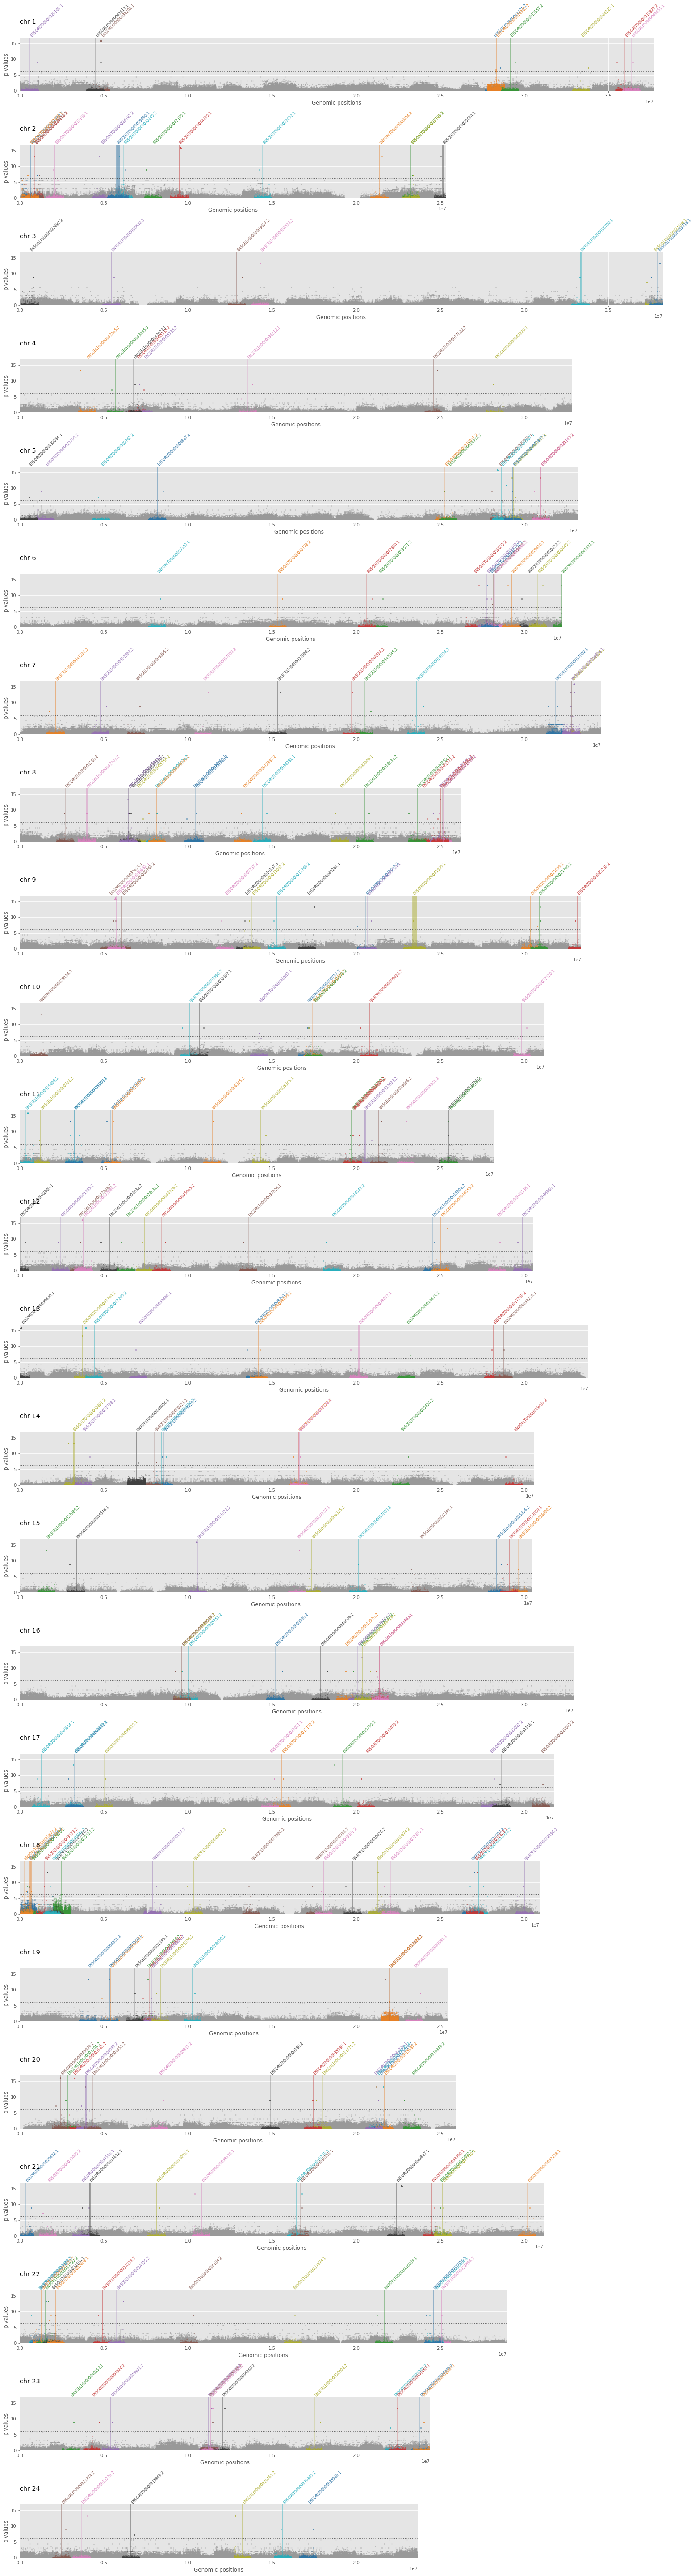

In [51]:
plot_copenhagen (
    data_fn = "./limix/eQTL_pval_500k.tsv",
    fasta_fn = "../pycoSnake_pipeline/results/input/genone/genome.fa",
    tx_info_fn = "../pycoSnake_pipeline/results/input/transcriptome/transcriptome.tsv",
    out_fn = "results_plots/copenhagen_pval.png",
    pval_threshold=1e-6, pval_min=1e-16, pval_type="pval")

#### Plot adjusted pVals

Load eQTL results
Load chromosome length
Load transcripts info
Compute variables
Generate plots
Processing chromosome 1
Processing chromosome 2
Processing chromosome 3
Processing chromosome 4
Processing chromosome 5
Processing chromosome 6
Processing chromosome 7
Processing chromosome 8
Processing chromosome 9
Processing chromosome 10
Processing chromosome 11
Processing chromosome 12
Processing chromosome 13
Processing chromosome 14
Processing chromosome 15
Processing chromosome 16
Processing chromosome 17
Processing chromosome 18
Processing chromosome 19
Processing chromosome 20
Processing chromosome 21
Processing chromosome 22
Processing chromosome 23
Processing chromosome 24


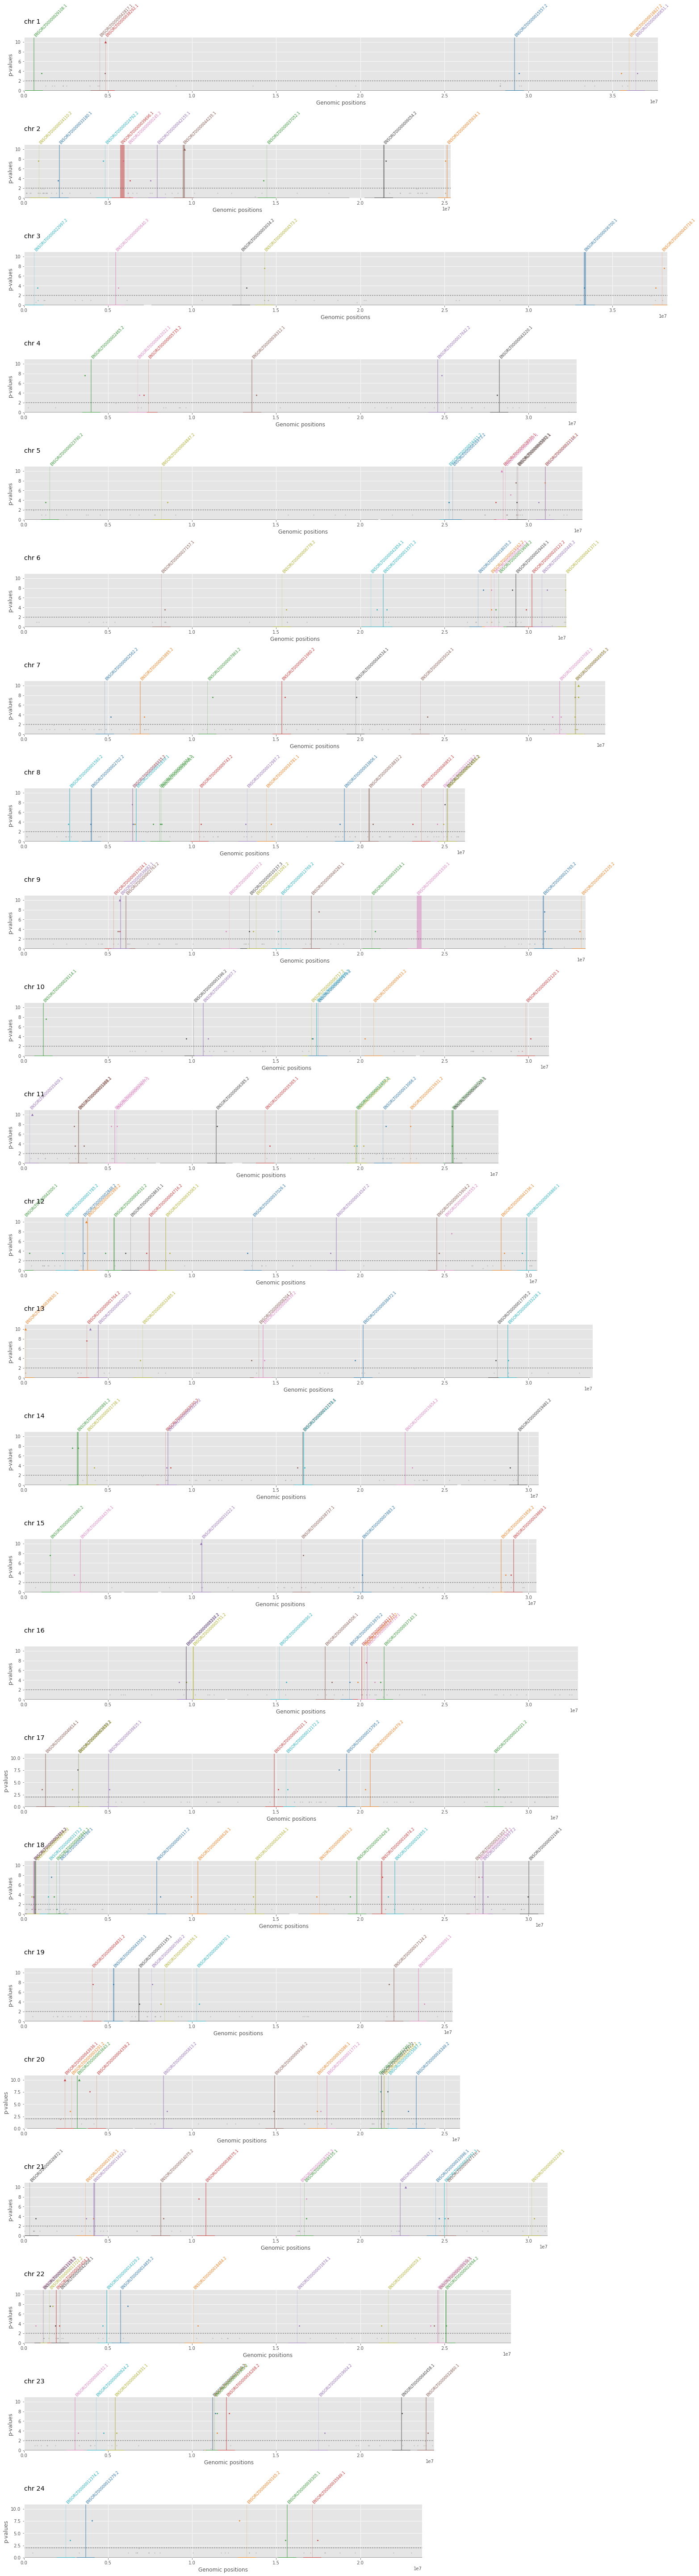

In [52]:
plot_copenhagen (
    data_fn = "./limix/eQTL_pval_adj_500k.tsv",
    fasta_fn = "../pycoSnake_pipeline/results/input/genone/genome.fa",
    tx_info_fn = "../pycoSnake_pipeline/results/input/transcriptome/transcriptome.tsv",
    out_fn = "results_plots/copenhagen_pval_adj.png",
    pval_threshold=1e-2, pval_min=1e-10, pval_type="pval")

### Manhattan

#### Define functions

In [4]:
def plot_manhattan (data_fn, fasta_fn, out_fn, n_best=3, max_pval=15, sig_pval=6, pval_type="pval"):
    
    print ("Load chromosome length")
    chr_len_df = pd.DataFrame(columns=["start", "end"])
    start = 0
    with pyfaidx.Fasta(fasta_fn) as fa:
        for c in fa:
            if c.name != "MT":
                chr_len_df.loc[c.name]=[start,start+len(c)-1]
                start+=len(c)
    
    print ("Load eQTL results")
    df = pd.read_csv(data_fn, sep="\t")
    df[pval_type] = df[pval_type].fillna(1.0)
    df[pval_type] = df[pval_type].clip(np.nextafter(np.float64(0), np.float64(1)), 1.0)
    
    print ("Select best pvalues")
    best_pval_res = []
    for tx, tx_df in df.groupby("transcript_id"):
        sorted_pval = tx_df.sort_values(pval_type)
        best_pval = sorted_pval.iloc[0:n_best]
        best_pval_res.append(best_pval)

    best_pval_df = pd.concat(best_pval_res)
    best_pval_df = best_pval_df.sort_values(["chrom", "pos"])
    
    print ("Plot data")
    # define palettes for significant and non significant hits
    pal = itertools.cycle(sns.color_palette("muted", desat=0.8))
    chr_col = {chr_id:next(pal) for chr_id in chr_len_df.index}
    pal_sig = itertools.cycle(sns.color_palette("dark", desat=0.8))
    chr_col_sig = {chr_id:next(pal_sig) for chr_id in chr_len_df.index}

    xmax = chr_len_df.end.max()
    with pl.style.context("ggplot"):
        fig = pl.figure(figsize=(40, 10))

        # plot data
        ax = pl.subplot2grid((10,1), (0,0), rowspan=9)
        ax.set_ylim(0,max_pval+0.5)
        ax.set_xlim(0,xmax)

        ax.set_xticks(list(chr_len_df.start))
        ax.tick_params(axis="x", labelbottom=False, bottom=False)
        ax.tick_params(axis="y", labelsize=14)

        for idx, line in best_pval_df.iterrows():
            log_pval = -np.log10(line[pval_type])
            x = line.pos+chr_len_df.loc[str(line.chrom), "start"]
            y = log_pval if log_pval<max_pval else max_pval
            color = chr_col[str(line.chrom)] if log_pval<sig_pval else chr_col_sig[str(line.chrom)]
            s = 20 if log_pval<sig_pval else 50
            marker = "." if log_pval<max_pval else "^"

            ax.scatter(x, y, color=color, marker=marker, s=s)

        # Plot sig limit
        ax.axhline(sig_pval, color="0.25", ls=":")

        #plot chromosomes 
        ax = pl.subplot2grid((10,1), (9,0), colspan=1)
        ax.grid(False)
        ax.axis(False)
        ax.set_xlim(0,xmax) 

        for chr_id, line in chr_len_df.iterrows():
            ax.axvspan(line.start, line.end, color=chr_col_sig[chr_id])
            ax.text(line.start+(line.end-line.start)/2, y=0.5, s=f"chr{chr_id}", horizontalalignment='center', verticalalignment='center', color="white", weight=550, fontsize=14)
    
    pl.show()
    fig.savefig(out_fn, bbox_inches='tight')

#### Plot non-adjusted pVals

Load chromosome length
Load eQTL results
Select best pvalues
Plot data


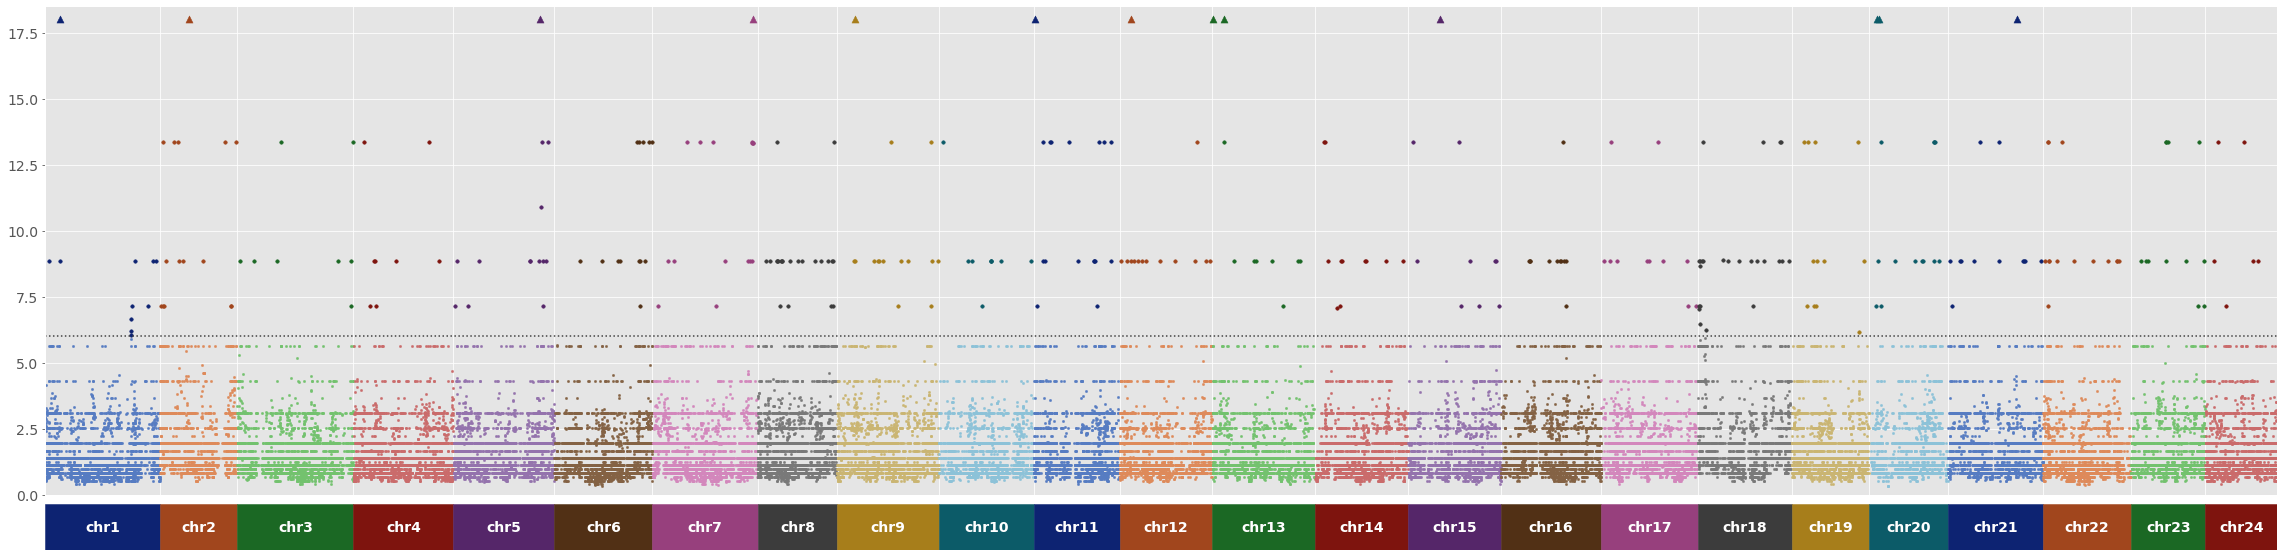

In [5]:
plot_manhattan (
    data_fn="./limix/eQTL_pval_500k.tsv", 
    fasta_fn="../pycoSnake_pipeline/results/input/genone/genome.fa", 
    out_fn="results_plots/manhattan_pval.png", 
    n_best=5, max_pval=18, sig_pval=6, pval_type="pval")

#### Plot adjusted pVals

Load chromosome length
Load eQTL results
Select best pvalues
Plot data


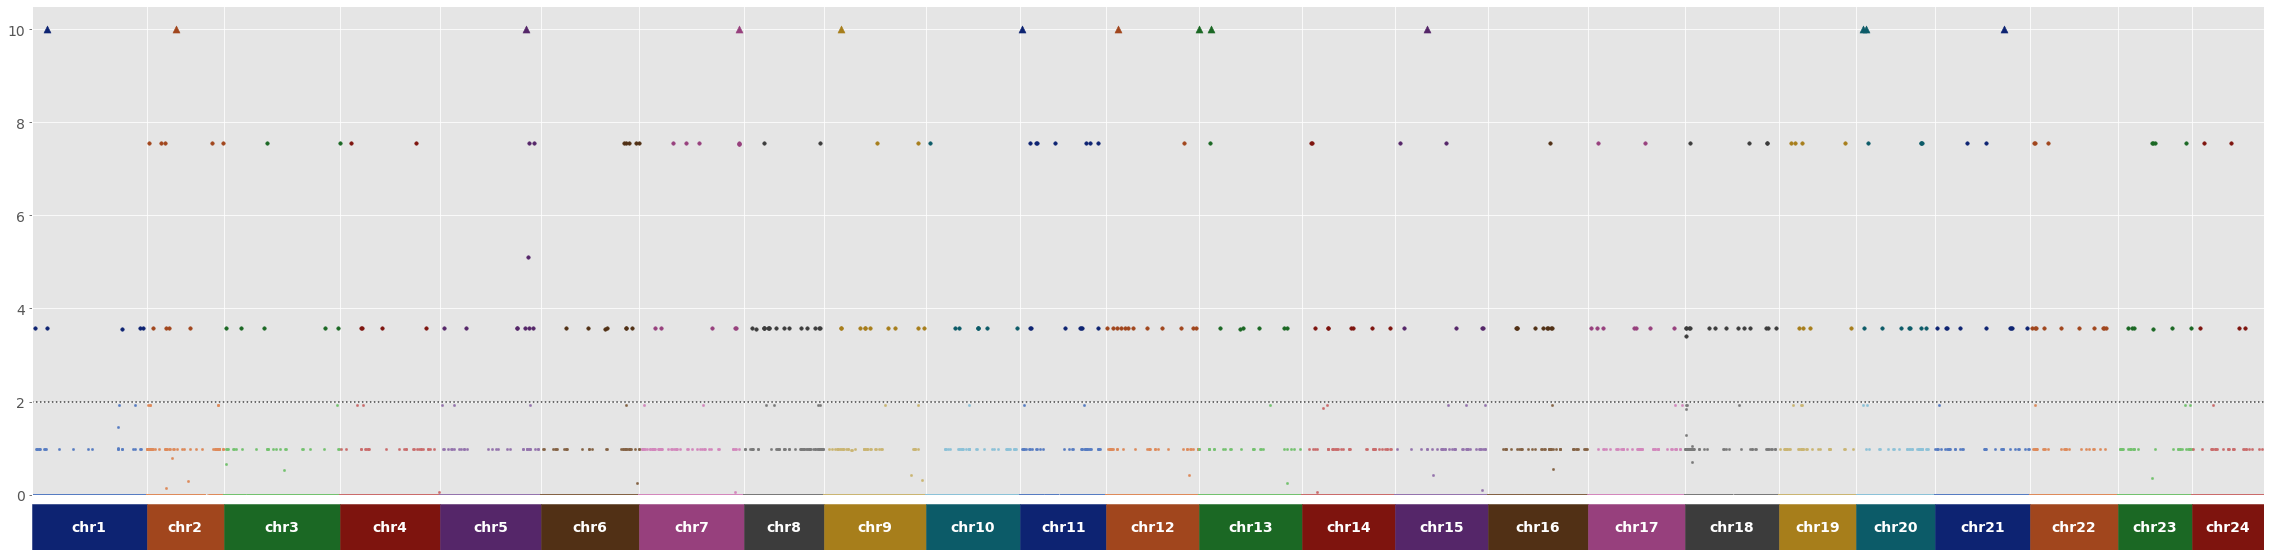

In [55]:
plot_manhattan (
    data_fn="./limix/eQTL_pval_adj_500k.tsv", 
    fasta_fn="../pycoSnake_pipeline/results/input/genone/genome.fa", 
    out_fn="results_plots/manhattan_pval_adj.png", 
    n_best=5, max_pval=10, sig_pval=2, pval_type="pval")

### Plot expression per genotype for top pValues

#### Define functions

In [54]:
def plot_expr_geno (data_df, G, Y, out_fn_prefix, top=8, tx_id=None, chrom=None, start=None, end=None, sort_val="pval", ncols=4, max_pval=1e-6):
    
    data_df = data_df[data_df["pval"]<=max_pval]
    
    # Sort and pick top
    if chrom:
        data_df = data_df[data_df["chrom"]==chrom]
        if start:
            data_df = data_df[data_df["pos"]>=start]
        if end:
            data_df = data_df[data_df["pos"]<=end]
    
    if tx_id:
        data_df = data_df[data_df["transcript_id"]==tx_id]
        
    data_df = data_df.sort_values(sort_val)
    if top:
        data_df = data_df.head(top)
    n_snp = len(data_df)
    
    print(f"Found {n_snp} SNPs")
    data_df = data_df.reset_index(drop=True)
    
    # compute ploting grid 
    row_heigh = 4
    col_width = 8
    nrows = n_snp//ncols
    if n_snp%ncols:
        nrows+=1
    
    all_genotype_df = pd.DataFrame()
    #all_expression_df = pd.DataFrame()
    
    with pl.style.context("ggplot"):
        fig, axes = pl.subplots(nrows=nrows, ncols=ncols, figsize=(col_width*ncols, row_heigh*nrows), sharex=True)
        try:
            axes = list(itertools.chain.from_iterable(axes))
        except TypeError:
            pass
        
        snp_ids = []
        for idx, line in tqdm(data_df.iterrows()):
            snp_id = line.snp_id
            snp_chrom = line.chrom
            snp_pos = line.pos
            snp_tx = line.transcript_id
            snp_pval = line.pval

            # Select genotypes
            g = G.where((G.snp == snp_id), drop=True)
            genotypes = []
            for i in g.values:
                if i[0] == 0:
                    genotypes.append("AA")
                elif i[0] == 1:
                    genotypes.append("AB")
                elif i[0] == 2:
                    genotypes.append("BB")

            # Select phenotype
            y = Y.xs(snp_tx, level=3, drop_level=False).iloc[0]
            expression = y.values
            tx_chrom = y.name[0]
            tx_start = y.name[1]
            tx_end = y.name[2]
            
            # Get line ids
            geno_line_id = list(g.sample.values)
            pheno_line_id = list(y.index.values)
            assert geno_line_id==pheno_line_id

            res_df = pd.DataFrame({"line_id":geno_line_id, "genotype":genotypes, "expression":expression})
            sns.stripplot(x="genotype", y="expression", data=res_df, order=["AA", "AB", "BB"], ax=axes[idx])
            sns.boxenplot(x="genotype", y="expression", data=res_df, order=["AA", "AB", "BB"], ax=axes[idx], color="0.7", showfliers=False)
            axes[idx].set_xlabel("")
            axes[idx].set_title ("Transcript {} (chr-{}:{:,}-{:,}) \n SNP {} (chr-{}:{:,}) \n pvalue:{:.3e}".format(
                snp_tx, tx_chrom, tx_start, tx_end, snp_id, snp_chrom, snp_pos, snp_pval), fontsize=10)
            
            snp_ids.append(snp_id)
            genotype_df = res_df.set_index("line_id", drop=True)
            genotype_df = genotype_df.rename(columns={"genotype":snp_id})
            genotype_df = genotype_df[[snp_id]]
            if all_genotype_df.empty:
                all_genotype_df = genotype_df
            else:
                all_genotype_df = pd.merge(all_genotype_df, genotype_df, left_index=True, right_index=True)
        
        pl.subplots_adjust(hspace=0.5)
        pl.show()

        fig.savefig(out_fn_prefix+".svg", bbox_inches='tight')
        
        #display(data_df)
        data_df.to_csv(out_fn_prefix+"_eqtl.tsv", sep="\t", index=False)
        all_genotype_df = all_genotype_df.sort_values(snp_ids)
        #display(all_genotype_df)
        all_genotype_df.to_csv(out_fn_prefix+"_genotypes.tsv", sep="\t", index=True)

#### Load data

In [49]:
print("Load phenotypes")
Y_raw = pd.read_csv(f"tx_expression/filtered_tpm.tsv", sep="\t", index_col=[0,1,2,3])
Y_norm = pd.read_csv(f"tx_expression/filtered_norm_tpm.tsv", sep="\t", index_col=[0,1,2,3])

print("Load genotypes")
G = pandas_plink.read_plink1_bin (bed=f"plink_pruned/medaka.bed", bim=f"plink_pruned/medaka.bim", fam=f"plink_pruned/medaka.fam", verbose=False)
G = G.sortby("sample")

print ("Load eQTL results")
df = pd.read_csv("./limix/eQTL_sig_pval_500k.tsv", sep="\t")

Load phenotypes
Load genotypes
Load eQTL results


/nfs/software/birney/adrien/miniconda3/envs/eQTL/lib/python3.6/site-packages/xarray/core/indexing.py:1302: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


#### Selected regions

0it [00:00, ?it/s]

Found 9 SNPs


9it [00:04,  1.85it/s]


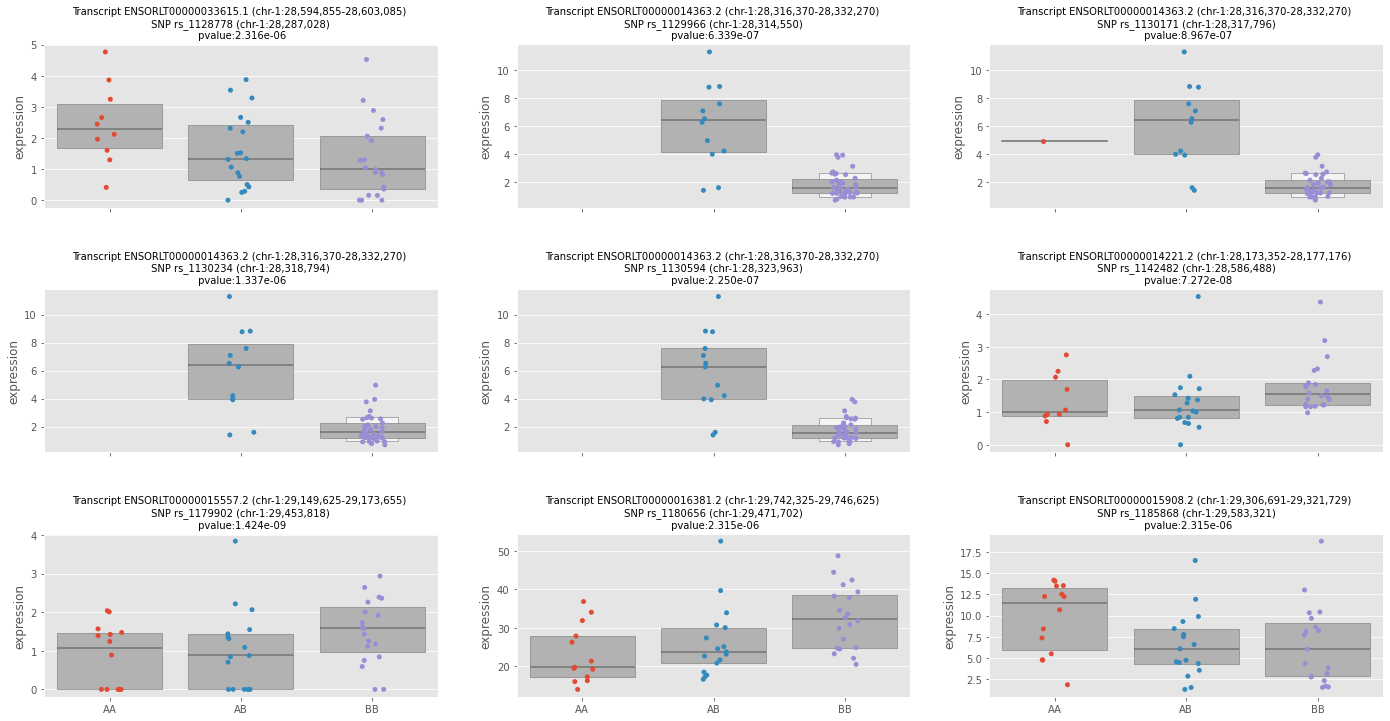

In [55]:
plot_expr_geno(df, G=G, Y=Y_raw, out_fn_prefix="./results_plots/expression_tpm_raw_top_eQTL_chr1", top=None, chrom=1, start=2.7e7, end=3e7, sort_val="pos", ncols=3, max_pval=1e-5)

Found 6 SNPs


6it [00:03,  1.96it/s]


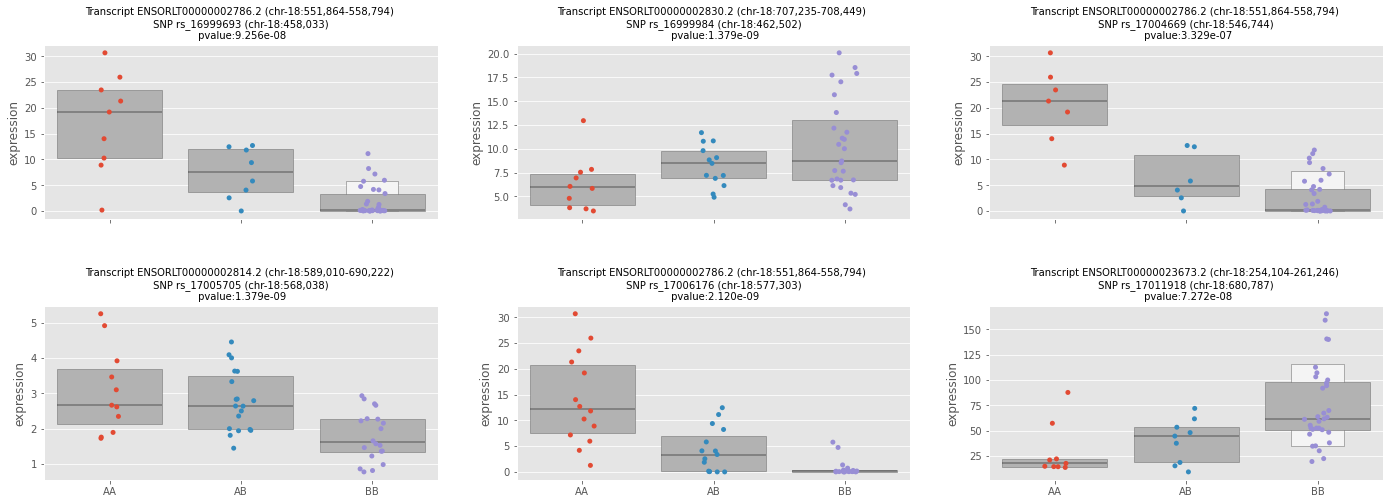

In [56]:
plot_expr_geno(df, G=G, Y=Y_raw, out_fn_prefix="./results_plots/expression_tpm_raw_top_eQTL_chr18", top=None, chrom=18, start=400000, end=700000, sort_val="pos", ncols=3)

0it [00:00, ?it/s]

Found 3 SNPs


3it [00:01,  2.09it/s]


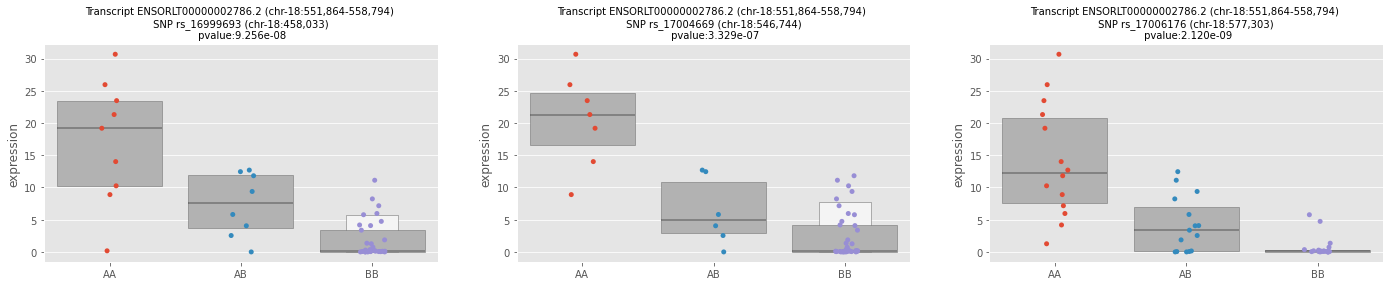

In [57]:
plot_expr_geno(df, G=G, Y=Y_raw, out_fn_prefix="./results_plots/expression_tpm_raw_top_eQTL_ENSORLT00000002786.2", top=None, tx_id="ENSORLT00000002786.2", sort_val="pos", ncols=3)

In [ ]:
plot_expr_geno(df, G=G, Y=Y_raw, out_fn_prefix="./results_plots/expression_tpm_raw_top_eQTL", top=80)

Found 80 SNPs


80it [00:50,  1.59it/s]


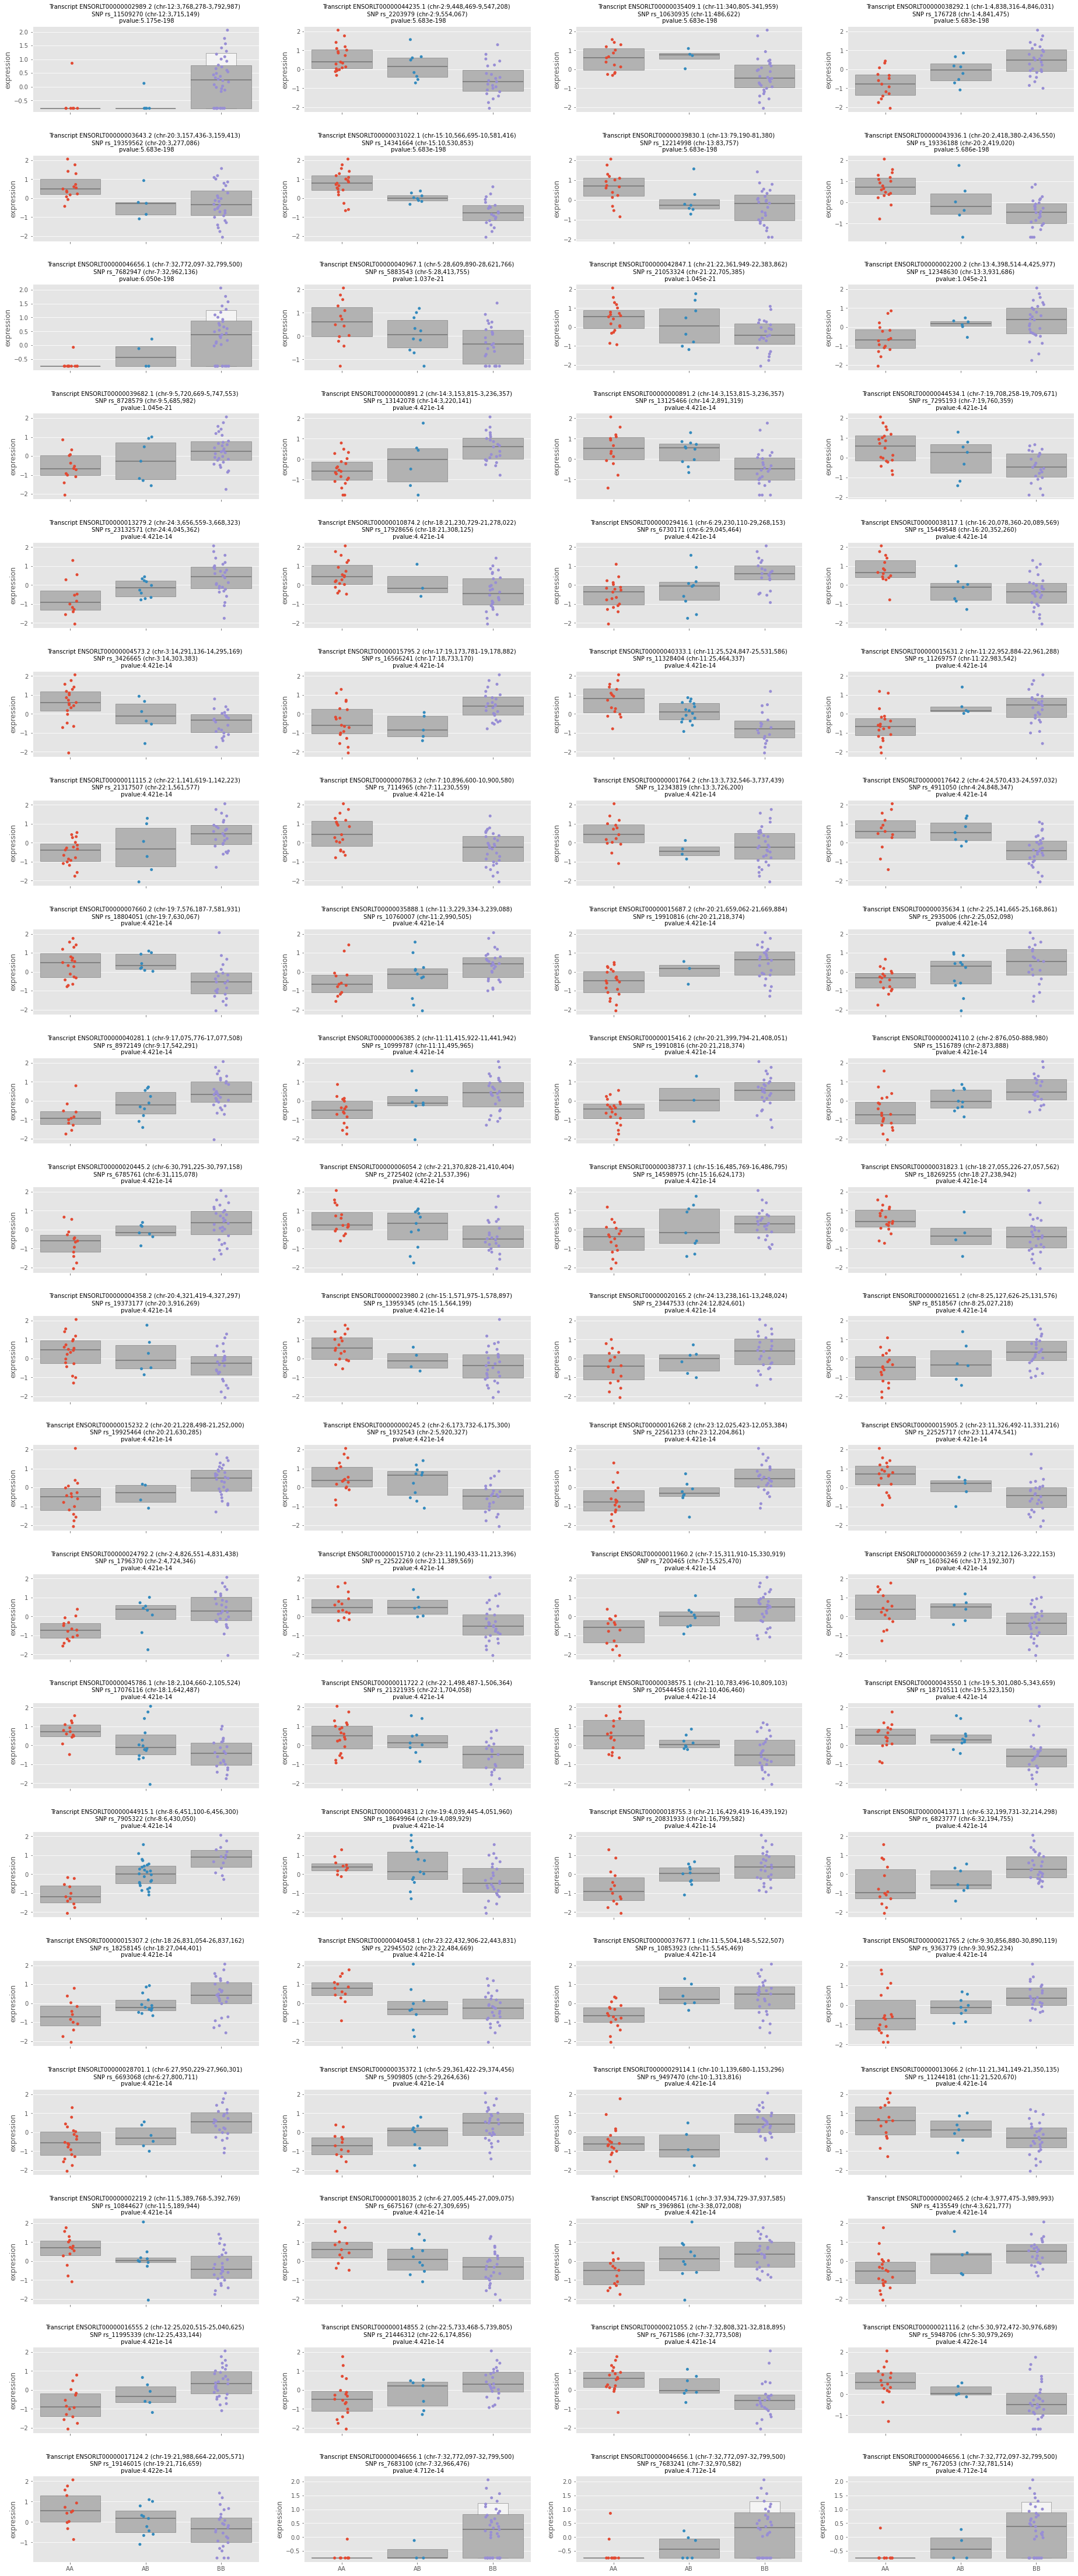

KeyError: 'rs_19910816'

In [64]:
plot_expr_geno(df, G=G, Y=Y_norm, out_fn_prefix="./results_plots/expression_tpm_norm_top_eQTL", top=80)

#### Explore ENSORLT00000002786 candidate 

In [63]:
eqtl_df = pd.read_csv("./results_plots/expression_tpm_raw_top_eQTL_ENSORLT00000002786.2_eqtl.tsv", sep="\t")
with open("./results_plots/eQTL_ENSORLT00000002786.2.bed", "w") as fp:
    for i in eqtl_df.itertuples():
        fp.write(f"{i.chrom}\t{i.pos}\t{i.pos+1}\t{i.snp_id}\n")
head("./results_plots/eQTL_ENSORLT00000002786.2.bed")

Only 3 lines in the file
18 458033 458034 rs_16999693 
18 546744 546745 rs_17004669 
18 577303 577304 rs_17006176 



In [88]:
geno_df = pd.read_csv("./results_plots/expression_tpm_raw_top_eQTL_ENSORLT00000002786.2_genotypes.tsv", sep="\t", index_col=0)
DNA_sample_df = pd.read_csv("/nfs/research1/birney/projects/medaka/inbred_panel/medaka-alignments-release-94/sample_link/cram_file_to_line_ids.txt", sep="\t", index_col=1)
DNA_sample_df.head()

for g in ("AA", "AB", "BB"):
    s = (geno_df==g).all(axis=1)
    s = s[s==True].index
    print(f"Genotype: {g}")
    s = DNA_sample_df.loc[s].sort_values("cram_file")
    display(s)

Genotype: AA


cram_file
line            
50_2   22013_4#5
55_2   22013_5#3
94_1   22013_6#2
133_2  22218_2#5
15_1   22218_4#2
137_4  22218_8#3
135_2  24259_2#1

Genotype: AB


cram_file
line            
32_2   22013_3#4
17_1   22024_1#2
59_2   22024_3#2
49_1   22218_5#2
139_4  22218_8#5
32_2   24271_7#5

Genotype: BB


cram_file
line              
11_2     22013_2#3
13_2     22013_2#4
14_1     22013_2#5
23_1     22013_3#1
84_2     22013_6#1
95_1     22013_6#3
21_2     22024_1#4
40_1     22024_2#4
59_1     22024_3#1
62_2     22024_3#4
91_1     22218_1#2
104_1    22218_1#3
8_2      22218_3#5
11_1     22218_4#1
69_1     22218_5#3
80_1     22218_5#5
117_2    22218_6#2
140_3    22218_8#1
84_2     24259_1#1
125_1    24259_1#4
132_4_1  24259_1#5

## Metagene

In [ ]:
# pval_threshold = 0.01

# print ("Load transcripts info")
# tx_info_df = pd.read_csv("../pycoSnake_pipeline/results/input/transcriptome/transcriptome.tsv",sep="\t", dtype={"chrom_id":str})
# tx_info_df = tx_info_df[["transcript_id", "start","end","strand"]]
# tx_info_df = tx_info_df.rename(columns={"start":"tx_start","end":"tx_end","strand":"tx_strand"})

# print ("Load eQTL results")
# eqtl_df = pd.read_csv("./limix/eQTL_pval_adj_500k.tsv", sep="\t", dtype={"chrom":str})
# eqtl_df = eqtl_df[["transcript_id", "pos","pval"]]
# eqtl_df = eqtl_df[eqtl_df["pval"]<=pval_threshold]

# print ("Merge df")
# df = pd.merge(eqtl_df, tx_info_df, on="transcript_id", how="left")

# print ("Retain best pvalue per transcript")
# l = []
# for tx, tx_df in df.groupby("transcript_id"):
#     tx_df = tx_df.sort_values("pval")
#     l.append(tx_df.iloc[0])
# df = pd.DataFrame(l)

# print(len(df))
# display(df.head(10))

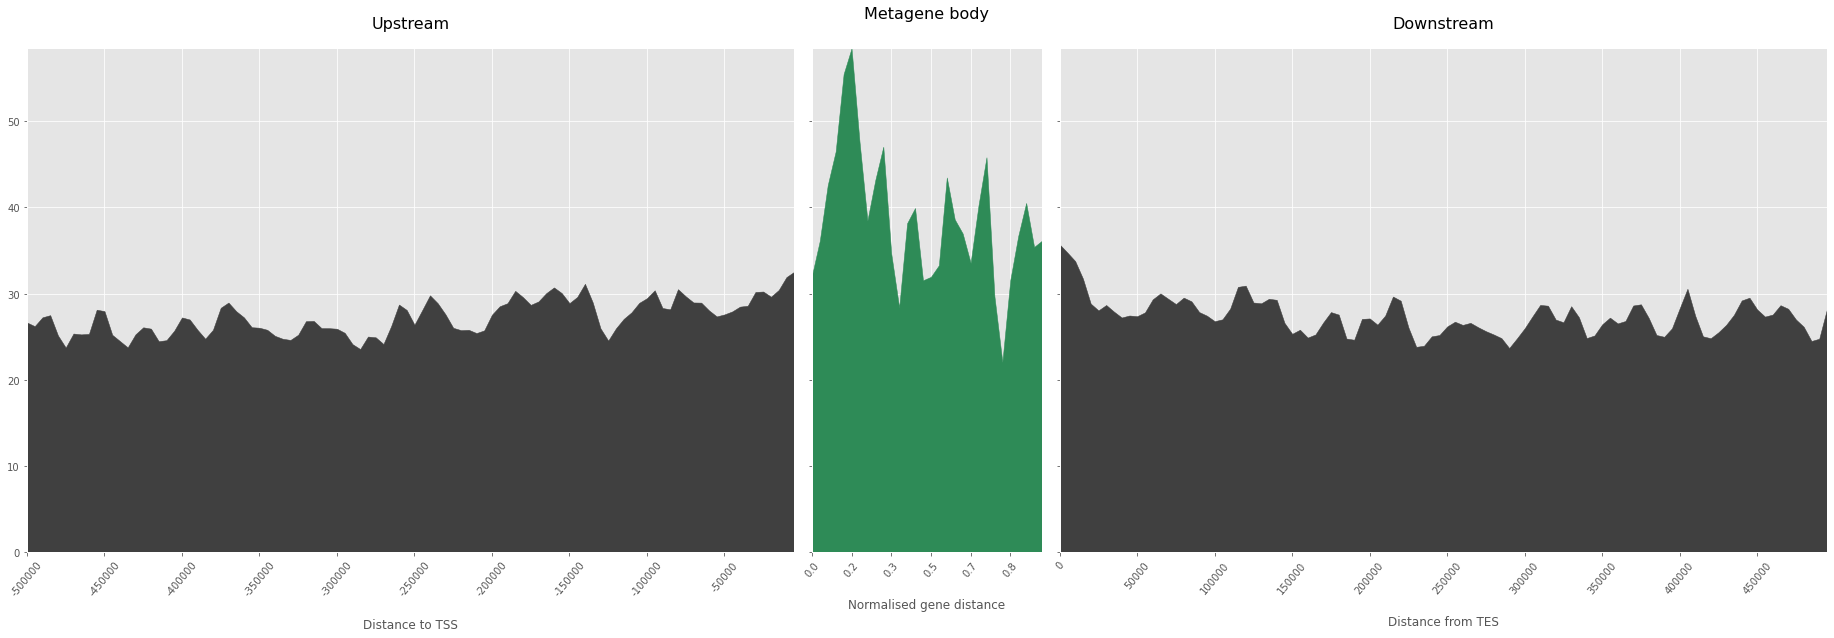

In [35]:
df = pd.read_csv("./limix/eQTL_sig_pval_500k.tsv", sep="\t", dtype={"chrom":str})

external_n_bins = 100
internal_n_bins = 30
extend = 500000

#res_d = defaultdict(Counter)
res_d=OrderedDict()
res_d["upstream"] = [0 for _ in range(external_n_bins)]
res_d["downstream"] = [0 for _ in range(external_n_bins)]
res_d["internal"] = [0 for _ in range(internal_n_bins)]
tx_len_list = []
for tx, tx_df in df.groupby("transcript_id"):
    
    tx_start = tx_df.iloc[0].tx_start
    tx_end = tx_df.iloc[0].tx_end
    tx_strand = tx_df.iloc[0].tx_strand
    tx_len_list.append(tx_end-tx_start)
    
    vmin = tx_start-extend
    vmax = tx_start
    upstream_len_bin = (vmax-vmin)//external_n_bins
    upstream_bins = np.linspace(vmin, vmax-upstream_len_bin, external_n_bins, dtype=int)

    vmin = tx_end
    vmax = tx_end+extend
    downstream_len_bin = (vmax-vmin)//external_n_bins
    downstream_bins = np.linspace(vmin, vmax-downstream_len_bin, external_n_bins, dtype=int)
    
    vmin = tx_start
    vmax = tx_end
    internal_len_bin = (vmax-vmin)//internal_n_bins
    internal_bins = np.linspace(vmin, vmax-internal_len_bin, internal_n_bins, dtype=int)
        
    for row in tx_df.itertuples():
        if row.pos <= tx_start:
            index = np.digitize(row.pos, upstream_bins, right=False)-1
            if tx_strand == "+":
                res_d["upstream"][index]+=1000/upstream_len_bin
            elif tx_strand == "-":
                res_d["downstream"][external_n_bins-index-1]+=1000/downstream_len_bin
        elif row.pos >= tx_end:
            index = np.digitize(row.pos, downstream_bins, right=False)-1
            if tx_strand == "+":
                res_d["downstream"][index]+=1000/downstream_len_bin
            elif tx_strand == "-":
                res_d["upstream"][external_n_bins-index-1]+=1000/upstream_len_bin
        else:
            index = np.digitize(row.pos, internal_bins, right=False)-1
            if tx_strand == "+":
                res_d["internal"][index]+=1000/internal_len_bin
            elif tx_strand == "-":
                    res_d["internal"][internal_n_bins-index-1]+=1000/internal_len_bin

external_xticks_bins = int((external_n_bins/10)+1)
internal_xticks_bins = int((internal_n_bins/5)+1)

ymax = 0
p_res_d=OrderedDict()
for lab, y in res_d.items():
    y = gaussian_filter1d(y, sigma=0.8)
    p_res_d[lab] = y
    if max(y)>ymax:
        ymax = max(y)
    
tot_bin_len = 2*external_n_bins+internal_n_bins
spacer_len = tot_bin_len/100
tot_bin_len+=spacer_len*2

with pl.style.context("ggplot"):
    fig = pl.figure(figsize=(25, 7))
    
    ax = pl.axes([0,0,external_n_bins/tot_bin_len,1])
    ax.fill_between(np.arange(0, external_n_bins), p_res_d["upstream"], color="0.25")
    ax.set_xticks(np.linspace(0, external_n_bins, external_xticks_bins))
    ax.set_xticklabels(np.linspace(-extend, 0, external_xticks_bins, dtype=int), rotation=50)
    ax.set_xlim(0, external_n_bins-1)
    ax.set_ylim(0, ymax)
    ax.set_ylabel("Length normalised number of eQTL hits")
    ax.set_title("Upstream", pad=20, size=16)
    ax.set_xlabel("Distance to TSS", labelpad=20)
    ax.set_ylabel("", labelpad=20)
       
    ax = pl.axes([(external_n_bins+spacer_len)/tot_bin_len,0,internal_n_bins/tot_bin_len,1])    
    ax.fill_between(np.arange(0, internal_n_bins), p_res_d["internal"], color="seagreen")
    ax.set_xticks(np.linspace(0, internal_n_bins, internal_xticks_bins))
    ax.set_xticklabels(np.round(np.linspace(0, 1, internal_xticks_bins),1), rotation=50)
    ax.set_yticklabels([])
    ax.set_xlim(0, internal_n_bins-1)
    ax.set_ylim(0, ymax)
    ax.set_title("Metagene body", pad=30, size=16)
    ax.set_xlabel("Normalised gene distance", labelpad=20)

    ax = pl.axes([(external_n_bins+spacer_len*2+internal_n_bins)/tot_bin_len,0,external_n_bins/tot_bin_len,1])
    ax.fill_between(np.arange(0, external_n_bins), p_res_d["downstream"], color="0.25")
    ax.set_xticks(np.linspace(0, external_n_bins, external_xticks_bins))
    ax.set_xticklabels(np.linspace(0, extend, external_xticks_bins, dtype=int), rotation=50)
    ax.set_yticklabels([])
    ax.set_xlim(0, external_n_bins-1)
    ax.set_ylim(0, ymax)
    ax.set_title("Downstream", pad=20, size=16)
    ax.set_xlabel("Distance from TES", labelpad=20)
    
    pl.show()
    fig.savefig("./results_plots/metagene_pval_adj.svg", bbox_inches='tight')